In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle
import json
import sys
import argparse
import torch
import random
import os

from pathlib import Path
# Add the parent directory to the system path
sys.path.append(str(Path().resolve().parent))

from causal_meta_learners.causal_inference_modeling import *
from causal_meta_learners.experiment_setup import *
from causal_meta_learners.survival_models import *

# Load the results

In [3]:
all_results = []

# import all pickle files in the results directory
for file in os.listdir("results_full"):
    if file.endswith(".pickle"):
        with open(f"results_full/{file}", "rb") as f:
            all_results.append(pickle.load(f))


results_per_time_snapshot = {}

for result in all_results:
    results_per_time_snapshot[result['hyper_params']['minimum_num_time_steps']-1] = result

del all_results

In [4]:
all_causal_survival_forest_results = []

# import all pickle files in the results directory
for file in os.listdir("results_causal_survival_forest"):
    if file.endswith(".pickle"):
        with open(f"results_causal_survival_forest/{file}", "rb") as f:
            all_causal_survival_forest_results.append(pickle.load(f))


results_causal_survival_forest_per_time_snapshot = {}

for result in all_causal_survival_forest_results:
    results_causal_survival_forest_per_time_snapshot[result['hyper_params']['minimum_num_time_steps']-1] = result

del all_causal_survival_forest_results

In [5]:
survival_analysis_model_names = ['CoxPH', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
causal_inference_model_names = {'T-learner':'t-learner', 'S-learner':'s-learner', 'Matching':'matching'}

In [6]:
survival_analysis_metrics = {'C-index':'concordance_td', 'IBS':'integrated_brier_score', 'Time-Dependent AUC':'td_auc'}
survival_analysis_metrics_direction = {'C-index':1, 'IBS':-1, 'Time-Dependent AUC':1}

# Prediction Performance of the Survival Analysis Models

In [7]:
for time_snapshot in results_per_time_snapshot.keys():
   print(f"Time snapshot: {time_snapshot}: {list(results_per_time_snapshot[time_snapshot].keys())}") 

Time snapshot: 3: ['hyper_params', 'CoxPH', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
Time snapshot: 6: ['hyper_params', 'CoxPH', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
Time snapshot: 9: ['hyper_params', 'CoxPH', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
Time snapshot: 18: ['hyper_params', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
Time snapshot: 24: ['hyper_params', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
Time snapshot: 36: ['hyper_params', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']
Time snapshot: 12: ['hyper_params', 'RandomSurvivalForest', 'DeepSurv', 'DeepHit']


In [8]:
# print snapshots in time:
print("Snapshots in time:")
print(sorted(results_per_time_snapshot.keys()))

Snapshots in time:
[3, 6, 9, 12, 18, 24, 36]


In [9]:
prediction_performance_table_per_time_snapshot = {}

for time_snapshot, result in sorted(results_per_time_snapshot.items()):
    prediction_performance_table = {}
    for model_name in survival_analysis_model_names:
        current_model_table = {}
        for metric_name, metric_saved in survival_analysis_metrics.items():
            if model_name not in result.keys():
                current_model_table[metric_name] = None
            else:
                if metric_name == 'Time-Dependent AUC':
                    metric_value_repeats = [result[model_name][random_seed]['s-learner']['predictive_performance'][0][metric_saved][-1] for random_seed in result[model_name].keys()]
                else:
                    metric_value_repeats = [result[model_name][random_seed]['s-learner']['predictive_performance'][0][metric_saved] for random_seed in result[model_name].keys()]
                current_model_table[metric_name] = (np.mean(metric_value_repeats), np.std(metric_value_repeats))
        
        prediction_performance_table[model_name] = current_model_table
    prediction_performance_table_per_time_snapshot[time_snapshot] = prediction_performance_table

In [10]:
def format_value(value, decimal_places=4):
    """Format the mean and standard deviation with the given decimal precision."""
    if value is None:
        return "--"
    mean, std = value
    return f"{mean:.{decimal_places}f} ± {std:.{decimal_places}f}"


def generate_latex_table(snapshot_times, prediction_performance_table_per_time_snapshot, table_number, 
                         survival_analysis_model_names, survival_analysis_metrics, survival_analysis_metrics_direction,
                         table_font_size="small", decimal_places=4):
    """Generate LaTeX table for given snapshot times with bolded highest values in each column."""
    
    table_shape = "@{\\hspace{0.5cm}}".join([" c c c "]*len(snapshot_times))

    table = f"""
    \\begin{{table*}}[hbtp]
    \\setlength{{\\tabcolsep}}{{4pt}}
    \\{table_font_size}
    \\floatconts
      {{tab:table_{table_number}}}
      {{\caption{{Prediction Performance Across Time Snapshots}}}}
      {{\\begin{{tabular}}{{l {table_shape}}}
    \\toprule"""
    
    # Define column headers
    table += "\n    &" + " & ".join([f"\multicolumn{{3}}{{c}}{{{t} months}}" for t in snapshot_times]) + " \\\\"
    table += "\n    \\midrule"
    table += "\n    " + " & " + " & ".join(["$C^{td}$ & IBS & $\\text{AUC}^{td}$"] * len(snapshot_times)) + " \\\\"
    table += "\n    \\midrule"
    
    # Find max values for each column
    max_values = {t: {metric: (float('-inf')*survival_analysis_metrics_direction[metric],0) for metric in survival_analysis_metrics.keys()} for t in snapshot_times}
    for time_snapshot in snapshot_times:
        for model_name in survival_analysis_model_names:
            result = prediction_performance_table_per_time_snapshot.get(time_snapshot, {}).get(model_name, {})
            for metric_name in survival_analysis_metrics.keys():
                value = result.get(metric_name, None)
                if value is not None and (value[0]*survival_analysis_metrics_direction[metric_name]) > (max_values[time_snapshot][metric_name][0]*survival_analysis_metrics_direction[metric_name]):
                    max_values[time_snapshot][metric_name] = value
    
    # Fill in table values
    for model_name in survival_analysis_model_names:
        row = f"{model_name}"
        for time_snapshot in snapshot_times:
            result = prediction_performance_table_per_time_snapshot.get(time_snapshot, {}).get(model_name, {})
            for metric_name in survival_analysis_metrics.keys():
                value = result.get(metric_name, None)
                formatted_value = format_value(value, decimal_places)
                
                if value is not None and value == max_values[time_snapshot][metric_name]:
                    row += f" & \\textbf{{{formatted_value}}}"
                else:
                    row += f" & {formatted_value}"
        table += "\n    " + row + " \\\\"
    
    table += "\n    \\bottomrule"
    table += "\n    \end{tabular}}"
    table += "\n    \end{table*}"
    
    return table

In [11]:
# Define the decimal precision variable
DECIMAL_PLACES = 3
TABLE_FONT_SIZE = "footnotesize"  # Options: tiny, scriptsize, footnotesize, small, normalsize, large, etc.

# Define snapshot groups for the tables
table_snapshots = [[3, 6], [9, 12], [18, 24, 36]]

# Print LaTeX tables
for i, snapshots in enumerate(table_snapshots):
    print(generate_latex_table(snapshots, prediction_performance_table_per_time_snapshot, i+1, 
                               survival_analysis_model_names, survival_analysis_metrics, survival_analysis_metrics_direction,
                               TABLE_FONT_SIZE, DECIMAL_PLACES))
    print("\n\n")


    \begin{table*}[hbtp]
    \setlength{\tabcolsep}{4pt}
    \footnotesize
    \floatconts
      {tab:table_1}
      {\caption{Prediction Performance Across Time Snapshots}}
      {\begin{tabular}{l  c c c @{\hspace{0.5cm}} c c c }
    \toprule
    &\multicolumn{3}{c}{3 months} & \multicolumn{3}{c}{6 months} \\
    \midrule
     & $C^{td}$ & IBS & $\text{AUC}^{td}$ & $C^{td}$ & IBS & $\text{AUC}^{td}$ \\
    \midrule
    CoxPH & 0.639 ± 0.008 & 0.198 ± 0.004 & 0.681 ± 0.012 & 0.633 ± 0.011 & 0.189 ± 0.003 & 0.682 ± 0.011 \\
    RandomSurvivalForest & \textbf{0.659 ± 0.008} & \textbf{0.190 ± 0.003} & \textbf{0.705 ± 0.010} & \textbf{0.661 ± 0.012} & \textbf{0.181 ± 0.004} & \textbf{0.705 ± 0.011} \\
    DeepSurv & 0.646 ± 0.018 & 0.196 ± 0.005 & 0.689 ± 0.022 & 0.630 ± 0.010 & 0.190 ± 0.005 & 0.670 ± 0.010 \\
    DeepHit & 0.570 ± 0.036 & 0.240 ± 0.008 & 0.588 ± 0.044 & 0.575 ± 0.050 & 0.219 ± 0.018 & 0.613 ± 0.043 \\
    \bottomrule
    \end{tabular}}
    \end{table*}




    \begin{t

In [12]:
# Number of People in each time snapshot
for time_snapshot, result in sorted(results_per_time_snapshot.items()):
    print(f"Time snapshot: {time_snapshot} ", end="")
    num_patients_ = [len(current_dict_['causal_data_dict']['post_hoc']['total']['covered_by_injectable']) for random_seed, current_dict_ in result[list(result.keys())[-1]].items()]
    print(f"Number of patients: {np.mean(num_patients_)} ± {np.std(num_patients_)}")

Time snapshot: 3 Number of patients: 5951.0 ± 0.0
Time snapshot: 6 Number of patients: 4869.0 ± 0.0
Time snapshot: 9 Number of patients: 5211.0 ± 0.0
Time snapshot: 12 Number of patients: 4893.0 ± 0.0
Time snapshot: 18 Number of patients: 1029.0 ± 0.0
Time snapshot: 24 Number of patients: 799.0 ± 0.0
Time snapshot: 36 Number of patients: 3323.0 ± 0.0


# Causal Inference ATE from Different Survival Analysis Models at Different Time Snapshots

In [13]:
print("Number of Matches in the Matching Model:")
print(list(results_per_time_snapshot[3]['CoxPH']['2732']['matching'].keys()))
print()

num_matches_displayed = [1, 5, 20]

print("Number of Matches Displayed:")
print(num_matches_displayed)

Number of Matches in the Matching Model:
[1, 2, 5, 10, 20, 50, 100]

Number of Matches Displayed:
[1, 5, 20]


In [14]:
causal_inference_ate_table_per_time_snapshot = {}

for time_snapshot, result in sorted(results_per_time_snapshot.items()):
    causal_inference_ate_table = {}
    for model_name in survival_analysis_model_names:
        current_model_table = {}
        for causal_model_name, causal_model_saved in causal_inference_model_names.items():
            if causal_model_saved != 'matching':
                if model_name not in result.keys():
                    current_model_table[causal_model_name] = None
                else:
                    ate_repeats = [result[model_name][random_seed][causal_model_saved]['ATE'] for random_seed in result[model_name].keys()]
                    current_model_table[causal_model_name] = (np.mean(ate_repeats), np.std(ate_repeats))
            else:
                for num_matches_ in num_matches_displayed:
                    matching_str = causal_model_name + f" ({num_matches_})"
                    if model_name not in result.keys():
                        current_model_table[matching_str] = None
                    else:
                        ate_repeats = [result[model_name][random_seed][causal_model_saved][num_matches_]['ATE'] for random_seed in result[model_name].keys()]
                        current_model_table[matching_str] = (np.mean(ate_repeats), np.std(ate_repeats))
        causal_inference_ate_table[model_name] = current_model_table
    causal_inference_ate_table_per_time_snapshot[time_snapshot] = causal_inference_ate_table

In [15]:
causal_survival_forest_ate_table_per_time_snapshot = {}

for time_snapshot, result in sorted(results_causal_survival_forest_per_time_snapshot.items()):
    ate_repeats = [np.mean(result['CausalSurvivalForest'][random_seed]['ITE']) for random_seed in result['CausalSurvivalForest'].keys()]
    causal_survival_forest_ate_table_per_time_snapshot[time_snapshot] = {'CausalSurvivalForest': {'ATE': (np.mean(ate_repeats), np.std(ate_repeats))}}

In [16]:
def generate_causal_inference_table(time_snapshot, causal_inference_ate_table_per_time_snapshot,
                                    survival_analysis_model_names, causal_inference_meta_learners,
                                    causal_survival_forest_ate_table_per_time_snapshot=None,
                                    table_font_size="small", decimal_places=4):
    """Generate LaTeX table for a single snapshot time."""
    table = f"""
    \\begin{{table*}}[hbtp]
    \\setlength{{\\tabcolsep}}{{4pt}}
    \\{table_font_size}
    \\floatconts
      {{tab:table_time_{time_snapshot}}}
      {{\caption{{Causal Inference ATE Estimates at {time_snapshot} Months}}}}
      {{\\begin{{tabular}}{{l {'c ' * len(causal_inference_meta_learners)}}}
    \\toprule"""
    
    # Define column headers
    table += "\n    &" + " & ".join(causal_inference_meta_learners) + " \\\\"
    table += "\n    \midrule"
    
    # Fill in table values
    for model_name in survival_analysis_model_names:
        row = f"{model_name}"
        result = causal_inference_ate_table_per_time_snapshot.get(time_snapshot, {}).get(model_name, {})
        row += " & " + " & ".join([format_value(result.get(causal_model, None), decimal_places) for causal_model in causal_inference_meta_learners])
        table += "\n    " + row + " \\\\"

    if causal_survival_forest_ate_table_per_time_snapshot is not None:
        table += "\n    \midrule"
        row = f"CausalSurvivalForest"
        ate_value = causal_survival_forest_ate_table_per_time_snapshot.get(time_snapshot, {}).get('CausalSurvivalForest', None).get('ATE', None)
        row += f" &  \\multicolumn{{2}}{{c}}{{{format_value(ate_value, decimal_places)}}} "
        table += "\n    " + row + " \\\\"
    
    table += "\n    \\bottomrule"
    table += "\n    \end{tabular}}"
    table += "\n    \end{table*}"
    
    return table

In [17]:
# Define the decimal precision variable
DECIMAL_PLACES = 3
TABLE_FONT_SIZE = "footnotesize"  # Options: tiny, scriptsize, footnotesize, small, normalsize, large, etc.

# Print LaTeX tables
for time_snapshot in causal_inference_ate_table_per_time_snapshot.keys():
    print(generate_causal_inference_table(time_snapshot, causal_inference_ate_table_per_time_snapshot,
                                          survival_analysis_model_names, causal_inference_ate_table_per_time_snapshot[time_snapshot]['CoxPH'].keys(),
                                          causal_survival_forest_ate_table_per_time_snapshot,
                                          table_font_size=TABLE_FONT_SIZE, decimal_places=DECIMAL_PLACES))
    print("\n\n")


    \begin{table*}[hbtp]
    \setlength{\tabcolsep}{4pt}
    \footnotesize
    \floatconts
      {tab:table_time_3}
      {\caption{Causal Inference ATE Estimates at 3 Months}}
      {\begin{tabular}{l c c c c c }
    \toprule
    &T-learner & S-learner & Matching (1) & Matching (5) & Matching (20) \\
    \midrule
    CoxPH & -3.524 ± 0.274 & -3.644 ± 0.393 & -4.245 ± 0.005 & -4.280 ± 0.003 & -4.406 ± 0.002 \\
    RandomSurvivalForest & -2.317 ± 0.602 & -1.183 ± 0.363 & -1.615 ± 0.073 & -1.538 ± 0.054 & -1.978 ± 0.050 \\
    DeepSurv & -2.366 ± 0.603 & -1.986 ± 0.382 & -2.160 ± 1.014 & -2.101 ± 1.051 & -2.312 ± 1.223 \\
    DeepHit & -2.956 ± 6.663 & 0.417 ± 0.967 & 0.215 ± 0.481 & 0.241 ± 0.476 & 0.200 ± 0.501 \\
    \midrule
    CausalSurvivalForest &  \multicolumn{2}{c}{-3.045 ± 0.128}  \\
    \bottomrule
    \end{tabular}}
    \end{table*}




    \begin{table*}[hbtp]
    \setlength{\tabcolsep}{4pt}
    \footnotesize
    \floatconts
      {tab:table_time_6}
      {\caption{Causal 

## Contextualizing the treatment effects we’re estimating

In [ ]:
# Median estimated ATE across all (survival models (excluding DeepHit) and causal inference models) for snapshot tau
for tau in causal_inference_ate_table_per_time_snapshot.keys():
    if tau > 12: break
    list_of_ates = []
    for model_name, meta_learner_results in causal_inference_ate_table_per_time_snapshot[tau].items():
        if model_name == 'DeepHit':
            continue
        for causal_model_name, ate_value in meta_learner_results.items():
            if ate_value is not None:
                list_of_ates.append(ate_value[0])

    list_of_ates.append(causal_survival_forest_ate_table_per_time_snapshot[tau]['CausalSurvivalForest']['ATE'][0])

    print(f"Mean ATE across all models [at time snapshot {tau} moths]: {np.mean(list_of_ates):.0f}")

Mean ATE across all models [at time snapshot 3 moths]: -3
Mean ATE across all models [at time snapshot 6 moths]: -2
Mean ATE across all models [at time snapshot 9 moths]: -1
Mean ATE across all models [at time snapshot 12 moths]: -0


In [ ]:
tau = 3 # snapshot time [months]
mean_ATE = -3 # median ATE across all models at time snapshot tau
HORIZON = 12 # [months]


event_time_type_all = results_per_time_snapshot[tau]['RandomSurvivalForest']['2732']['causal_data_dict']['Y']['total']
treatment_assignment = results_per_time_snapshot[tau]['RandomSurvivalForest']['2732']['causal_data_dict']['A']['total']

event_time_type = event_time_type_all[event_time_type_all[:, 1] != 0] # only consider events
treatment_assignment = treatment_assignment[event_time_type_all[:, 1] != 0] # only consider events

condition_interval = (event_time_type[:, 0] > HORIZON) & (event_time_type[:, 0] <= (HORIZON + np.abs(mean_ATE)))
condition_interval_all = (event_time_type_all[:, 0] > HORIZON) & (event_time_type_all[:, 0] <= (HORIZON + np.abs(mean_ATE)))

people_with_event_during_condition_interval = event_time_type[condition_interval]
people_with_event_or_censoring_during_condition_interval = event_time_type_all[condition_interval_all]
treatment_assignment_during_condition_interval = treatment_assignment[condition_interval]
num_people_adhered_during_condition_interval = np.sum(1-treatment_assignment_during_condition_interval) # Adhered = 0, Non-adhered = 1
num_people_with_event_before_condition_interval = np.sum(event_time_type[:, 0] <= HORIZON)
num_people_before_condition_interval_all = np.sum(event_time_type_all[:, 0] <= HORIZON)

print(f'Condition interval: [{HORIZON},{HORIZON+np.abs(mean_ATE)}]')

print(f"Number of people with event or censoring during condition interval: {len(people_with_event_or_censoring_during_condition_interval)}")
print(f"Number of people with event during condition interval: {len(people_with_event_during_condition_interval)}")
print(f"Number of people with treatment assignment during condition interval: {len(treatment_assignment_during_condition_interval)}")
print(f"Number of people adhered during condition interval: {num_people_adhered_during_condition_interval}")
print(f"Number of people before condition interval: {num_people_with_event_before_condition_interval}")
print(f"Number of people before condition interval (including censoring): {num_people_before_condition_interval_all}")



Condition interval: [12,15]
Number of people with event or censoring during condition interval: 203
Number of people with event during condition interval: 156
Number of people with treatment assignment during condition interval: 156
Number of people adhered during condition interval: 95
Number of people before condition interval: 1077
Number of people before condition interval (including censoring): 1299


# ITE Based on Covered By Covariates (Graphical)

In [19]:
print("Number of Matches in the Matching Model:")
print(list(results_per_time_snapshot[3]['CoxPH']['2732']['matching'].keys()))
print()

num_matches_displayed = [1, 5]

print("Number of Matches Displayed:")
print(num_matches_displayed)

Number of Matches in the Matching Model:
[1, 2, 5, 10, 20, 50, 100]

Number of Matches Displayed:
[1, 5]


In [20]:
individual_treatment_effect_per_time_snapshot = {}

for time_snapshot, result in sorted(results_per_time_snapshot.items()):
    individual_treatment_effect_table = {}
    for model_name in survival_analysis_model_names:
        current_model_table = {}
        for causal_model_name, causal_model_saved in causal_inference_model_names.items():
            if causal_model_saved != 'matching':
                if model_name not in result.keys():
                    current_model_table[causal_model_name] = None
                else:
                    post_hoc_dict = result[model_name][random_seed]['causal_data_dict']['post_hoc']['total']
                    post_hoc_dict['A'] = result[model_name][random_seed]['causal_data_dict']['A']['total']
                    current_model_table[causal_model_name] = {'ITE': result[model_name][random_seed][causal_model_saved]['ITE'],
                                                              'post_hoc': post_hoc_dict}
            else:
                for num_matches_ in num_matches_displayed:
                    matching_str = causal_model_name + f" ({num_matches_})"
                    if model_name not in result.keys():
                        current_model_table[matching_str] = None
                    else:
                        post_hoc_dict = result[model_name][random_seed]['causal_data_dict']['post_hoc']['total']
                        post_hoc_dict['A'] = result[model_name][random_seed]['causal_data_dict']['A']['total']
                        current_model_table[matching_str] = {'ITE': result[model_name][random_seed][causal_model_saved][num_matches_]['ITE'],
                                                             'post_hoc': post_hoc_dict}
        individual_treatment_effect_table[model_name] = current_model_table
    individual_treatment_effect_per_time_snapshot[time_snapshot] = individual_treatment_effect_table

In [21]:
# Add the CausalSurvivalForest ITE
for time_snapshot, result in sorted(results_causal_survival_forest_per_time_snapshot.items()):
    post_hoc_dict = result['CausalSurvivalForest'][random_seed]['causal_data_dict']['post_hoc']['total']
    post_hoc_dict['A'] = result['CausalSurvivalForest'][random_seed]['causal_data_dict']['A']['total']
    individual_treatment_effect_per_time_snapshot[time_snapshot]['CausalSurvivalForest'] = {'Causal Survival Forest':
                                                                                            {'ITE': result['CausalSurvivalForest'][random_seed]['ITE'],
                                                                                             'post_hoc': post_hoc_dict}}

In [60]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import Counter


def plot_survival_analysis_results(ite_survival_meta_learners, 
                                   outer_grid_spacing_w=0.4, outer_grid_spacing_h=0.4, 
                                   inner_grid_spacing_w=0.4, inner_grid_spacing_h=0.4, 
                                   post_hoc_mode=None, figure_title=None):
    """
    Creates a hierarchical plot layout where each survival model has its own section,
    and within each section, there are subplots for different meta-learners.

    Args:
        ite_survival_meta_learners (dict): Dictionary of survival models, each containing a dictionary of meta-learners and their ITE results.
        outer_grid_spacing_h (float): Spacing between survival models' grids (outer grid) height.
        outer_grid_spacing_w (float): Spacing between survival models' grids (outer grid) width.
        inner_grid_spacing_h (float): Spacing between meta-learners' grids (inner grid) height.
        inner_grid_spacing_w (float): Spacing between meta-learners' grids (inner grid) width.
        post_hoc_mode (str): Post-hoc mode for plotting ITEs (if any).
        figure_title (str): Title for the entire figure (if any).

    Returns:
        None
    """
    num_survival_models = len(ite_survival_meta_learners)

    # Create the main figure
    fig = plt.figure(figsize=(20, 20))
    outer_grid = gridspec.GridSpec(int(np.ceil(num_survival_models / 2)), 2, wspace=outer_grid_spacing_w, hspace=outer_grid_spacing_h)

    # Add a title for the entire figure if provided
    if figure_title:
        fig.suptitle(figure_title, fontsize=16, fontweight='bold', y=0.98)

    # Iterate over survival models and create subplots for meta-learners
    for i, (survival_model_name, meta_learners_dict) in enumerate(ite_survival_meta_learners.items()):

        num_meta_learners = len(meta_learners_dict)
        num_meta_rows = (num_meta_learners + 1) // 2

        # Create a subplot for the survival model title
        ax_outer = fig.add_subplot(outer_grid[i])
        ax_outer.set_title(survival_model_name, fontsize=14, loc='center', pad=20)
        ax_outer.axis("off")

        # Create a grid for the current survival model's meta-learners
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            max(num_meta_rows, 2), 2, subplot_spec=outer_grid[i],
            wspace=inner_grid_spacing_w, hspace=inner_grid_spacing_h
        )

        # Plot each meta-learner in its own subplot
        for j, (meta_learner_name, ite_meta_learner) in enumerate(meta_learners_dict.items()):
            if ite_meta_learner is None: continue
            
            row, col = divmod(j, 2)
            ax = fig.add_subplot(inner_grid[row, col])
            
            plot_ITE(ax, ite_meta_learner, post_hoc_mode)

            # Show x-axis label only for subplots in the last row
            if row == num_meta_rows - 1:
                ax.set_xlabel("Estimated Individual Treatment Effects", fontsize=9)
            else:
                ax.set_xlabel("")  # Hide x-axis label for other rows
            
            # Show y-axis label only for subplots in the first column
            if col == 0:
                ax.set_ylabel("Probability", fontsize=9)
            else:
                ax.set_ylabel("")
                
            ax.set_title(f"{meta_learner_name}", fontsize=10)
            ax.legend(fontsize=8, loc='upper right')
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(0, ymax * (1.5 if post_hoc_mode!="covered_by" else 3))  # Add some padding to the y-axis

            if survival_model_name == 'CoxPH':
                ax.set_xlim(-10, 10)
            elif survival_model_name == 'RandomSurvivalForest':
                ax.set_xlim(-20, 20)
            elif survival_model_name == 'DeepSurv':
                ax.set_xlim(-20, 20)
            elif survival_model_name == 'DeepHit':
                ax.set_xlim(-10, 10)
            elif survival_model_name == 'CausalSurvivalForest':
                # ax.set_xlim(-10, 10)
                pass
            else:
                raise ValueError(f"Invalid survival model: {survival_model_name}")

    # Adjust the layout and display the plot
    # plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the figure title
    plt.show()


def plot_ITE(ax, ite_meta_learner, post_hoc_mode=None, top_k_medications=5):
    ite_list = ite_meta_learner['ITE']
    
    if post_hoc_mode is None:
        # Default histogram
        ax.hist(ite_list, bins=100, alpha=0.5, label=f'(ATE: {np.mean(ite_list):.1f} months)', color='purple', density=True)

    elif post_hoc_mode == "covered_by_injectable":
        
        injectable_list = np.array(ite_meta_learner['post_hoc']['covered_by_injectable'])[:, -1]
        
        injectable_list_v1 = ((injectable_list) & (1-ite_meta_learner['post_hoc']['A']))
        oral_list_v1 =     ((1-injectable_list) & (1-ite_meta_learner['post_hoc']['A']))
        non_adhered_list_v1 = (ite_meta_learner['post_hoc']['A'])

        version_dict = {1: "Separate Injectable, Oral, and Non-Adhered", 
                        2: "Separate Injectable and Non-adhered",
                        3: "Separate Injectable and Oral", 
                        4: "Separate Injectable and Others"}
        key = 3

        if key == 1:
            ite_covered_injectable = ite_list[injectable_list_v1 == 1]
            ite_covered_non_injectable = ite_list[oral_list_v1 == 1]
            ite_not_covered = ite_list[non_adhered_list_v1 == 1]

            # Plot histograms for each group with color coding
            num_bins = 10
            ax.hist(ite_covered_injectable, bins=num_bins, alpha=0.5, label=f'Covered by Injectable (ATE: {np.mean(ite_covered_injectable):.1f} months)', color='green', density=True)
            ax.hist(ite_covered_non_injectable, bins=num_bins, alpha=0.5, label=f'Covered by Non-Injectable (ATE: {np.mean(ite_covered_non_injectable):.1f} months)', color='orange', density=True)
            ax.hist(ite_not_covered, bins=num_bins, alpha=0.5, label=f'Non-Adhered (ATE: {np.mean(ite_not_covered):.1f} months)', color='red', density=True)
        elif key == 2:
            ite_covered = ite_list[injectable_list_v1 == 1]
            ite_not_covered = ite_list[non_adhered_list_v1 == 1]

            # Plot histograms for each group with color coding
            num_bins = 10
            ax.hist(ite_not_covered, bins=num_bins, alpha=0.5, label=f'Not Covered by Injectable (ATE: {np.mean(ite_not_covered):.1f} months)', color='red', density=True)
            ax.hist(ite_covered, bins=num_bins, alpha=0.5, label=f'Covered by Injectable (ATE: {np.mean(ite_covered):.1f} months)', color='green', density=True)
        elif key == 3:
            ite_covered = ite_list[injectable_list_v1 == 1]
            ite_covered_non_injectable = ite_list[oral_list_v1 == 1]

            # Plot histograms for each group with color coding
            num_bins = 10
            ax.hist(ite_covered_non_injectable, bins=num_bins, alpha=0.5, label=f'Covered by Non-Injectable (ATE: {np.mean(ite_covered_non_injectable):.1f} months)', color='orange', density=True)
            ax.hist(ite_covered, bins=num_bins, alpha=0.5, label=f'Covered by Injectable (ATE: {np.mean(ite_covered):.1f} months)', color='green', density=True)
        elif key == 4:
            ite_covered = ite_list[injectable_list_v1 == 1]
            ite_not_covered = ite_list[injectable_list_v1 != 1]
            
            # Plot histograms for each group with color coding
            num_bins = 10
            ax.hist(ite_not_covered, bins=num_bins, alpha=0.5, label=f'Not Covered by Injectable (ATE: {np.mean(ite_not_covered):.1f} months)', color='purple', density=True)
            ax.hist(ite_covered, bins=num_bins, alpha=0.5, label=f'Covered by Injectable (ATE: {np.mean(ite_covered):.1f} months)', color='green', density=True)


        # covered_by_some_medication_list = (np.array([len(med_list[-1]) for med_list in ite_meta_learner['post_hoc']['covered_by']]) != 0).astype(int)
        # injectable_list_v2 = np.array(ite_meta_learner['post_hoc']['covered_by_injectable'])[:, -1]
        # oral_list_v2 = ((1-injectable_list) & covered_by_some_medication_list)


        # Get the binary array (same size as ite_list)
        # post_hoc_list = np.array(ite_meta_learner['post_hoc']['covered_by_injectable'])[:, -1] #correct: last month injectable
        ## post_hoc_list = (np.sum(ite_meta_learner['post_hoc']['covered_by_injectable'], axis=1) >= 1).astype(int) #all months injectable

        # Separate ite_list into two groups based on post_hoc_list
        # ite_covered = ite_list[post_hoc_list == 1]
        # ite_not_covered = ite_list[post_hoc_list == 0]

        # Plot histograms for each group with color coding
        # num_bins = 10
        # ax.hist(ite_not_covered, bins=num_bins, alpha=0.5, label=f'Not Covered by Injectable (ATE: {np.mean(ite_not_covered):.1f} months)', color='orange', density=True)
        # ax.hist(ite_covered, bins=num_bins, alpha=0.5, label=f'Covered by Injectable (ATE: {np.mean(ite_covered):.1f} months)', color='green', density=True)

    elif post_hoc_mode == "covered_by":
        # Logic for handling 'covered_by' mode (to be implemented)

        post_hoc_list = ite_meta_learner['post_hoc']['covered_by']  # List of lists of medications

        # Flatten the list of lists and count medication frequencies
        flat_medications = [med for med_list in post_hoc_list for med in med_list[-1]]
        medication_counts = Counter(flat_medications)

        # Get the top k most common medications
        top_medications = [med for med, _ in medication_counts.most_common(top_k_medications)]

        # Plot the distribution for each of the top medications
        for med in top_medications:
            # Filter ITE values for patients using the current medication
            ite_for_med = [ite_list[i] for i, med_list in enumerate(post_hoc_list) if med in med_list[-1]]

            # Plot histogram for the current medication
            ax.hist(ite_for_med, bins=20, alpha=0.5, label=f'{med[:12]} (ATE: {np.mean(ite_for_med):.1f} months)', density=True)

    elif post_hoc_mode == "A":
        post_hoc_list = ite_meta_learner['post_hoc']['A']
        
        # Separate ite_list into two groups based on post_hoc_list
        ite_non_adhered = ite_list[post_hoc_list == 1]
        ite_adhered = ite_list[post_hoc_list == 0]

        # Plot histograms for each group with color coding
        ax.hist(ite_adhered, bins=20, alpha=0.5, label=f'Adhered Individuals (ATE: {np.mean(ite_adhered):.1f} months)', color='blue', density=True)
        ax.hist(ite_non_adhered, bins=20, alpha=0.5, label=f'Non-Adhered Individuals (ATE: {np.mean(ite_non_adhered):.1f} months)', color='red', density=True)


    else:
        raise ValueError(f"Invalid post-hoc mode: {post_hoc_mode}")


Survival Model: CoxPH


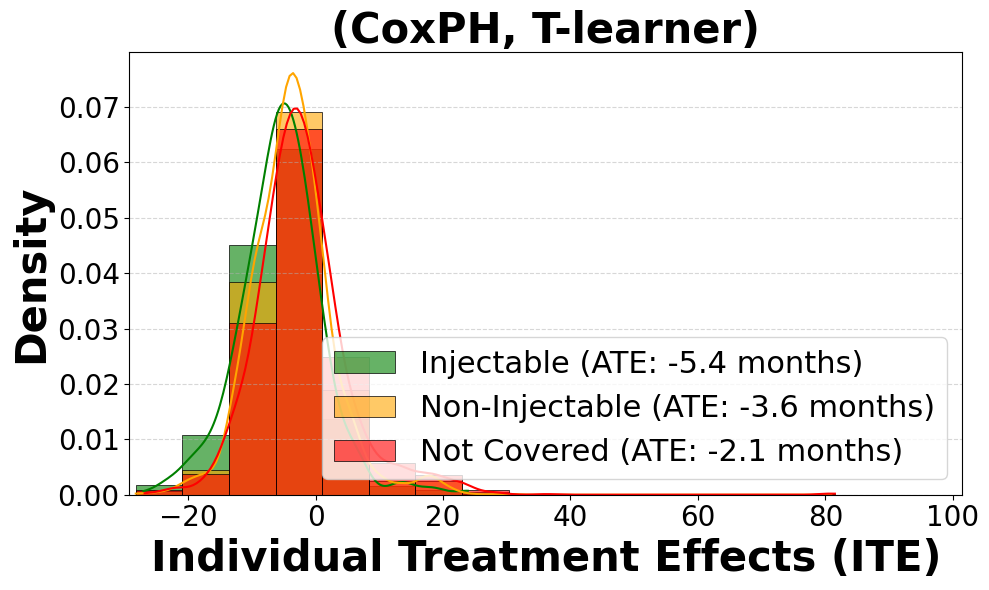

Survival Model: RandomSurvivalForest


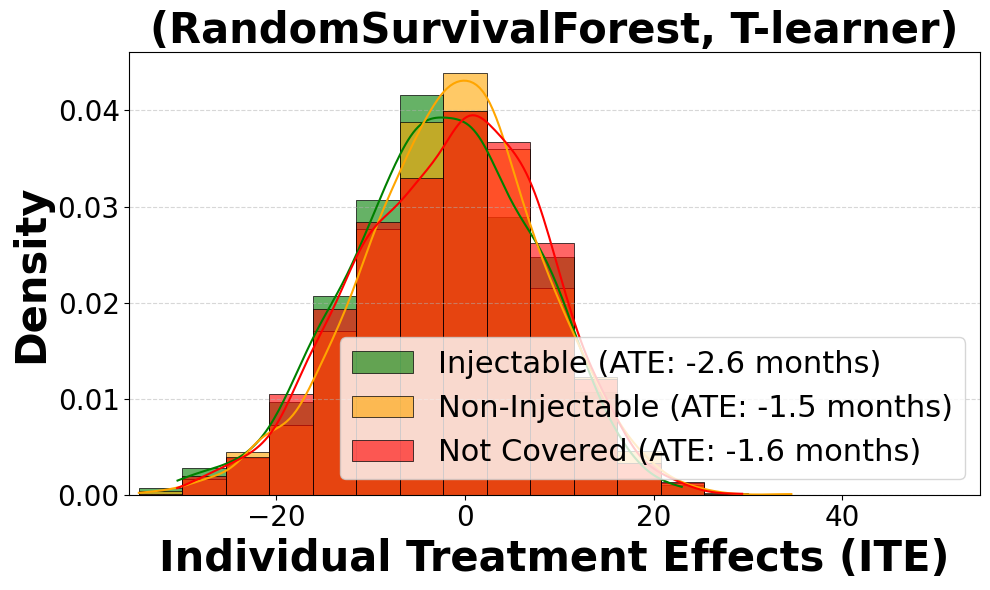

Survival Model: DeepSurv


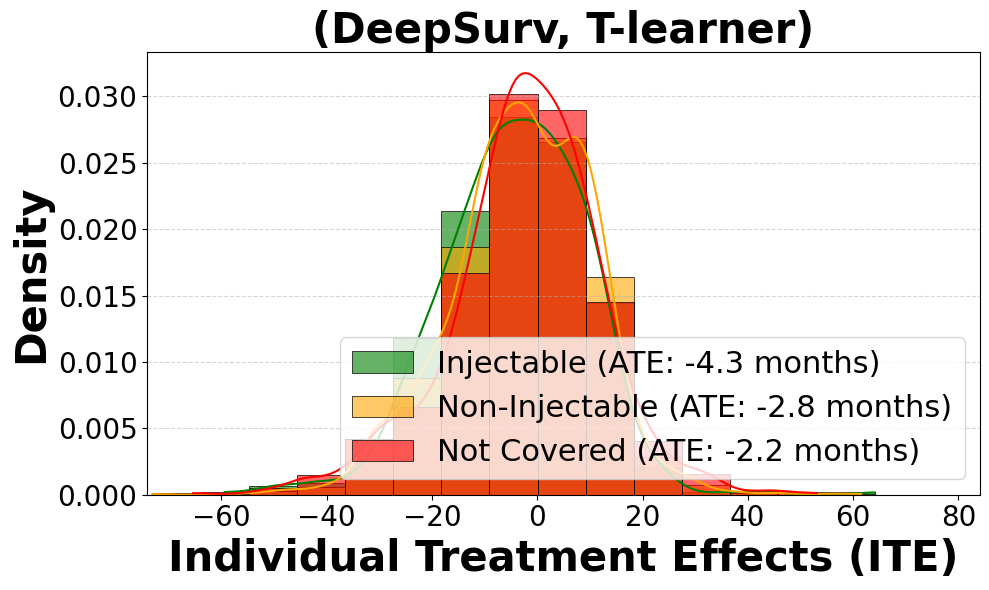

Survival Model: CausalSurvivalForest


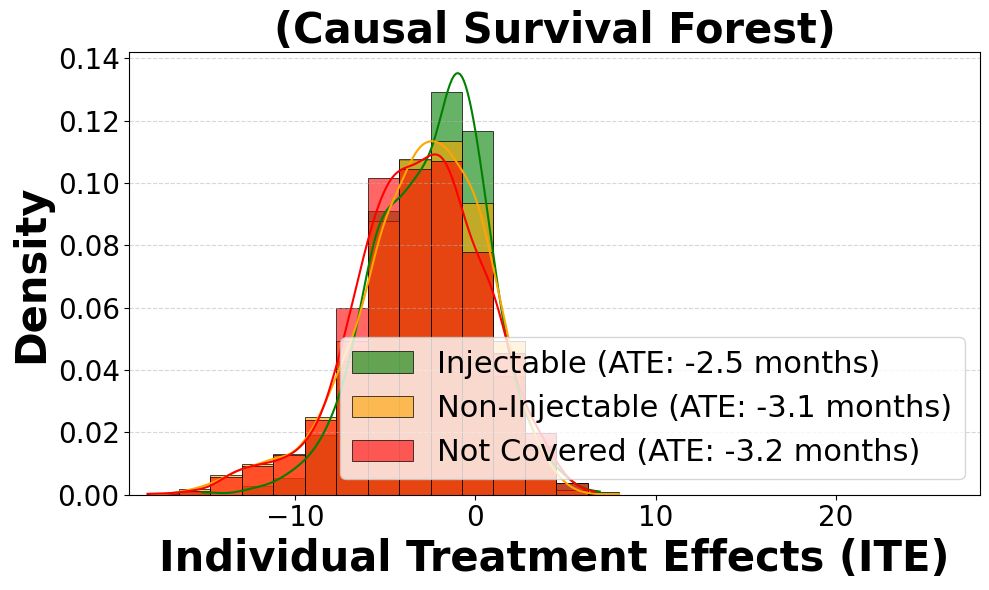

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ITE_injectable_type_paper_ready(ax, ite_meta_learner, survival_model_name, meta_learner_name, key=1, num_bins=15):
    """
    Creates paper-ready histograms for ITE distributions across different medication adherence groups with aligned bins.

    Args:
        ax (matplotlib.axes._subplots.AxesSubplot): Axis to plot on.
        ite_meta_learner (dict): Dictionary containing ITE and post-hoc data.
        survival_model_name (str): Name of the survival model.
        key (int): Key to determine the grouping logic.
    """
    ite_list = ite_meta_learner['ITE']
    injectable_list = np.array(ite_meta_learner['post_hoc']['covered_by_injectable'])[:, -1]

    injectable_list_v1 = ((injectable_list) & (1 - ite_meta_learner['post_hoc']['A']))
    oral_list_v1 = ((1 - injectable_list) & (1 - ite_meta_learner['post_hoc']['A']))
    non_adhered_list_v1 = (ite_meta_learner['post_hoc']['A'])

    # Plot groups based on the key
    groups = []
    colors = []
    labels = []

    if key == 1:
        groups.append(ite_list[injectable_list_v1 == 1])
        colors.append('green')
        labels.append('Injectable')

        groups.append(ite_list[oral_list_v1 == 1])
        colors.append('orange')
        labels.append('Non-Injectable')

        groups.append(ite_list[non_adhered_list_v1 == 1])
        colors.append('red')
        labels.append('Not Covered')

    elif key == 2:
        groups.append(ite_list[injectable_list_v1 == 1])
        colors.append('green')
        labels.append('Covered by Injectable')

        groups.append(ite_list[non_adhered_list_v1 == 1])
        colors.append('red')
        labels.append('Non-Adhered')

    elif key == 3:
        groups.append(ite_list[injectable_list_v1 == 1])
        colors.append('green')
        labels.append('Covered by Injectable')

        groups.append(ite_list[oral_list_v1 == 1])
        colors.append('orange')
        labels.append('Covered by Non-Injectable')

    elif key == 4:
        groups.append(ite_list[injectable_list_v1 == 1])
        colors.append('green')
        labels.append('Covered by Injectable')

        groups.append(ite_list[injectable_list_v1 != 1])
        colors.append('purple')
        labels.append('Not Covered by Injectable')

    # Precompute aligned bin edges
    all_data = np.concatenate(groups)
    bin_edges = np.histogram_bin_edges(all_data, bins=num_bins)

    # Plot histograms with aligned bins
    for group, color, label in zip(groups, colors, labels):
        sns.histplot(
            group, bins=bin_edges, kde=True, stat="density",
            ax=ax, label=f"{label} (ATE: {np.mean(group):.1f} months)",
            color=color, alpha=0.6, edgecolor="black", linewidth=0.5
        )

    # Set axis limits
    ax.set_xlim(bin_edges[0], bin_edges[-1])
    ax.set_ylim(0, None)

    # Customize axis labels and title
    ax.set_xlabel("Individual Treatment Effects (ITE)", fontsize=30, fontweight='bold')
    ax.set_ylabel("Density", fontsize=30, fontweight='bold')
    if meta_learner_name == 'Causal Survival Forest':
        title_str = '(Causal Survival Forest)'
    else:
        title_str = f"({survival_model_name}, {meta_learner_name})"
    ax.set_title(f"{title_str}", fontsize=30, fontweight='bold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xlim(ax.get_xlim()[0]-1, ax.get_xlim()[1]+20)

    # Add gridlines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Adjust legend
    # ax.legend(fontsize=10, loc='upper right')

ax_locations = ['lower right', 'lower right', 'lower right', 'lower right']
# Example usage for evaluations
time_snapshot = 3
key = 1
num_bins = 15
plot_counter = 0
for survival_model_name in individual_treatment_effect_per_time_snapshot[time_snapshot].keys():
    if survival_model_name == "DeepHit": 
        continue
    print(f"Survival Model: {survival_model_name}")
    meta_learner_name = 'Causal Survival Forest' if survival_model_name == 'CausalSurvivalForest' else 'T-learner'

    fig, ax = plt.subplots(figsize=(10, 6))
    plot_ITE_injectable_type_paper_ready(ax, individual_treatment_effect_per_time_snapshot[time_snapshot][survival_model_name][meta_learner_name], 
                                         survival_model_name, meta_learner_name, key, num_bins)
    
    # Adjust legend
    ax.legend(fontsize=22, loc=ax_locations[plot_counter%len(ax_locations)])
    
    plt.tight_layout()
    # plt.savefig(f"ITE_{survival_model_name}_{meta_learner_name}_injectable_type.pdf")
    plt.show()

    plot_counter += 1


Survival Model: CoxPH
Meta-learner: T-learner


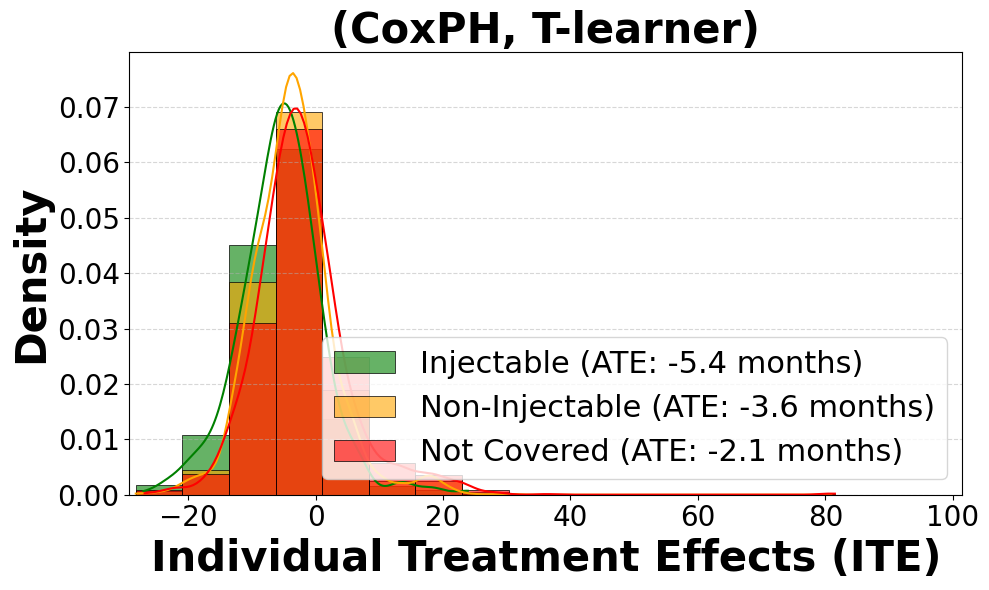

Meta-learner: S-learner


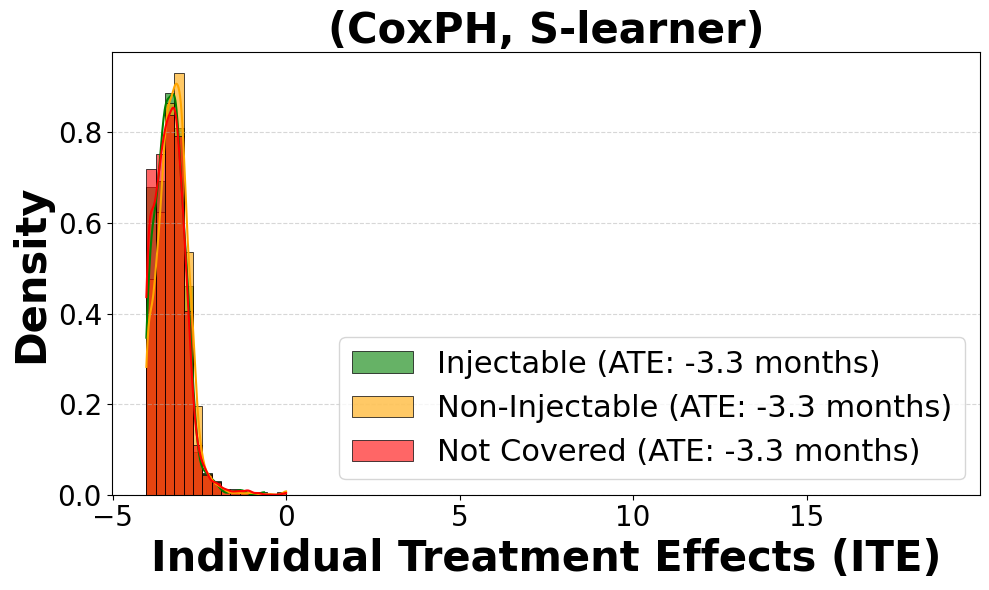

Meta-learner: Matching (1)


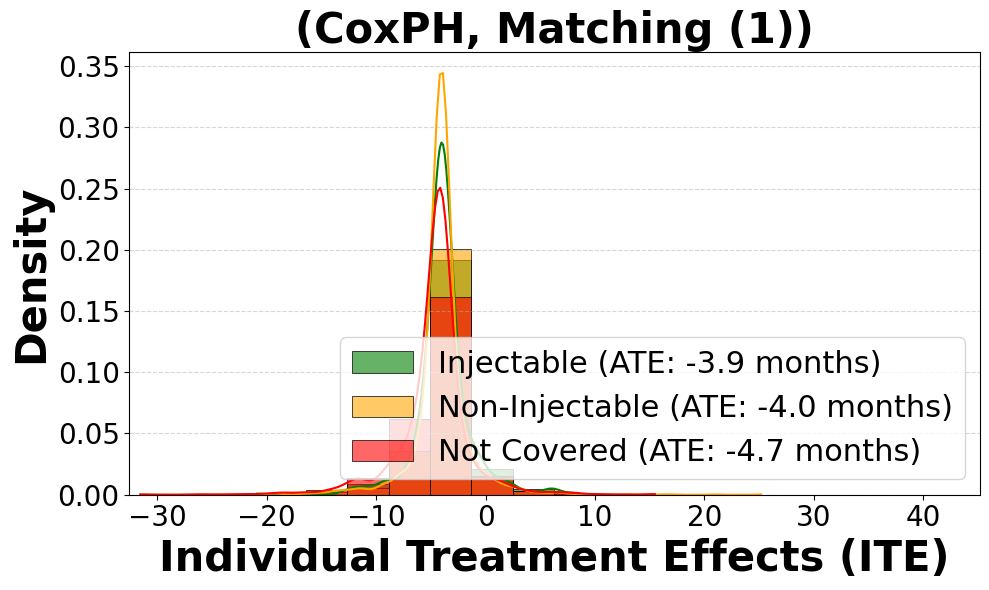

Meta-learner: Matching (5)


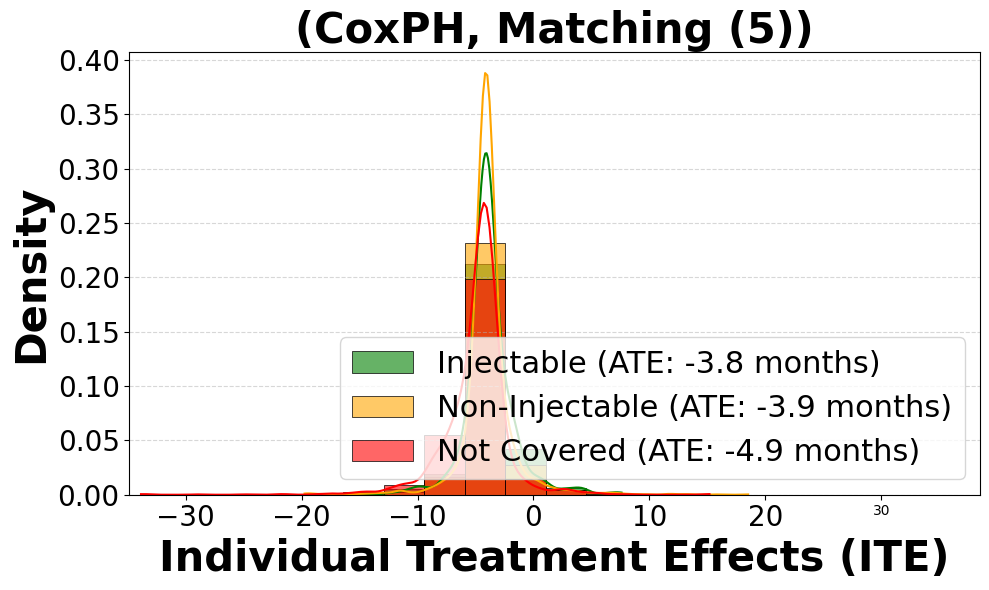

Survival Model: RandomSurvivalForest
Meta-learner: T-learner


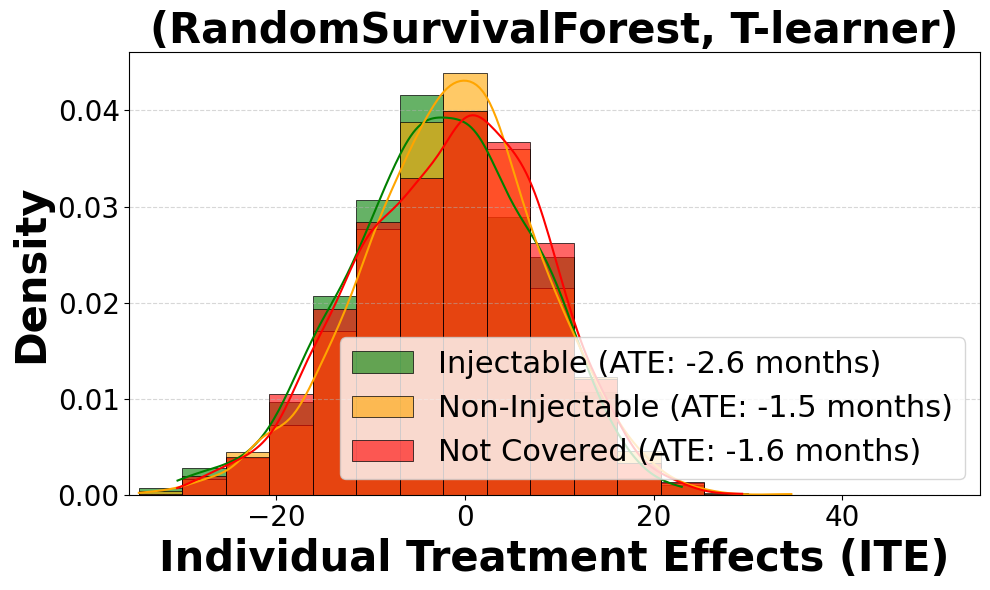

Meta-learner: S-learner


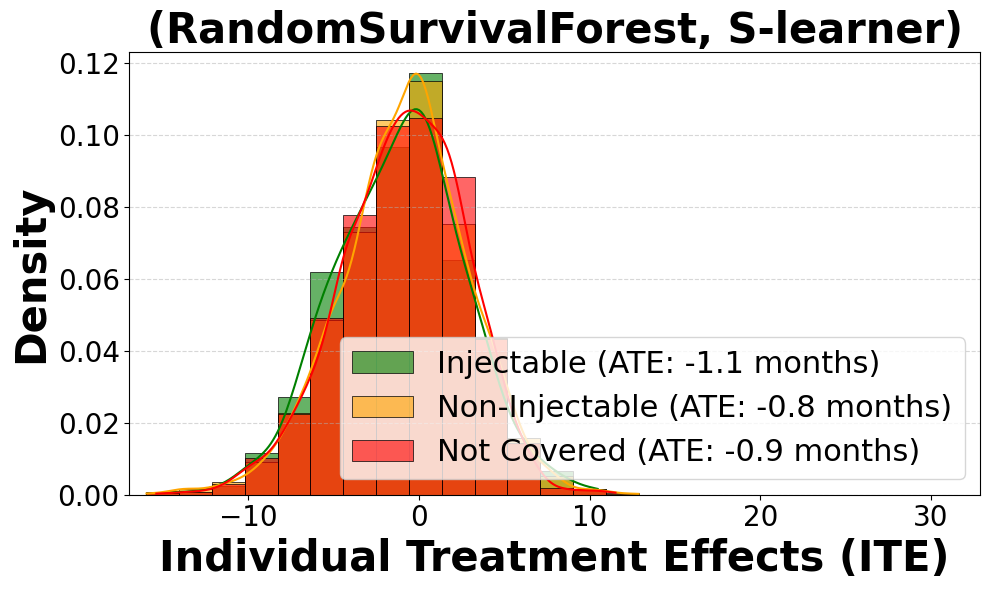

Meta-learner: Matching (1)


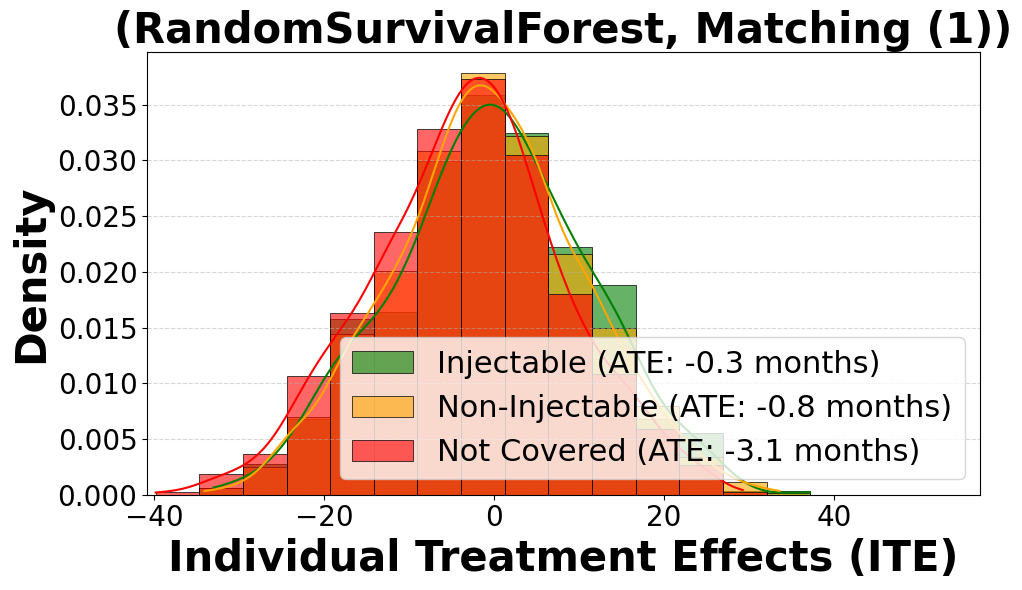

Meta-learner: Matching (5)


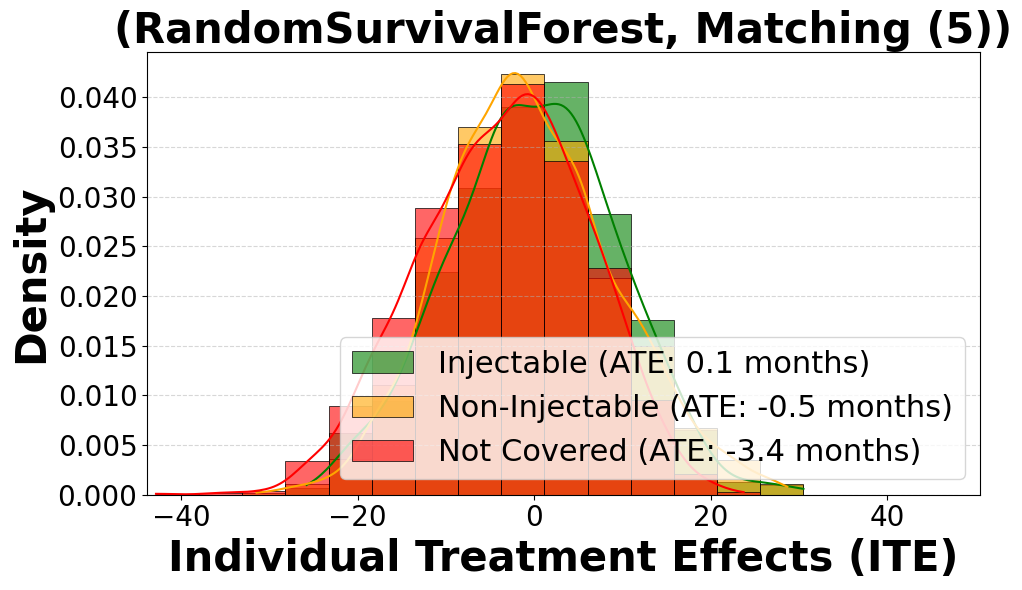

Survival Model: DeepSurv
Meta-learner: T-learner


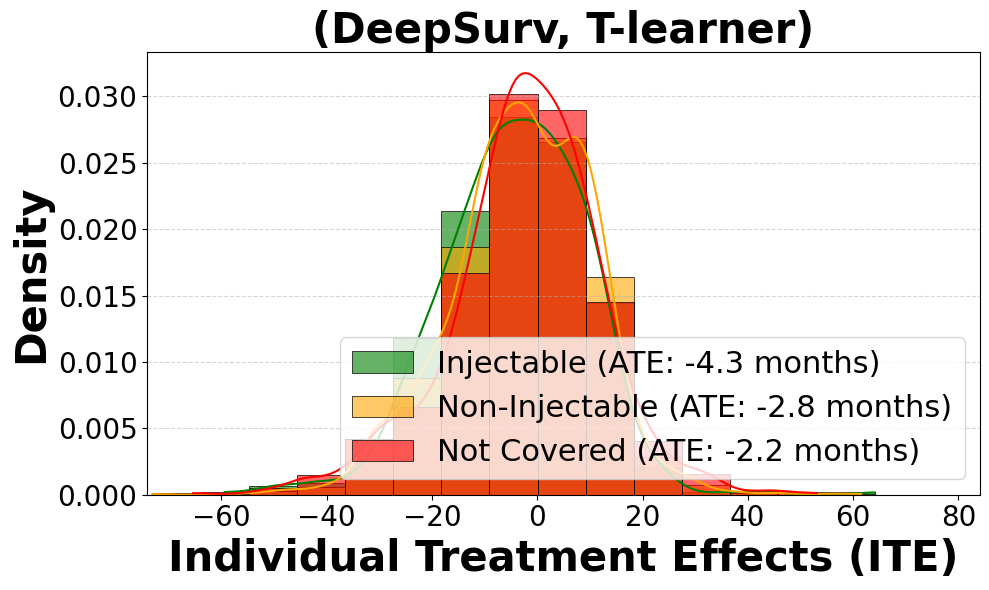

Meta-learner: S-learner


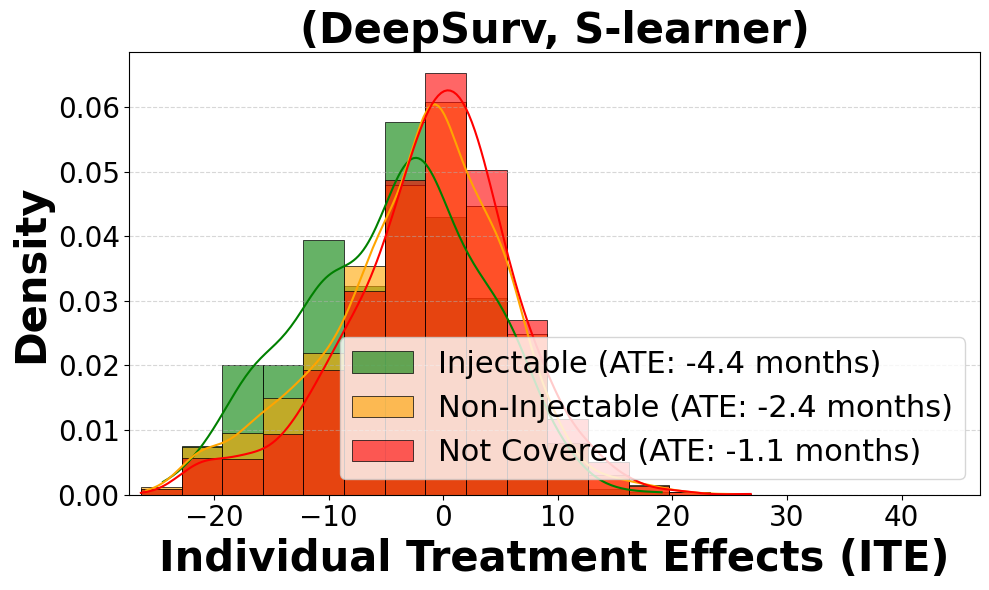

Meta-learner: Matching (1)


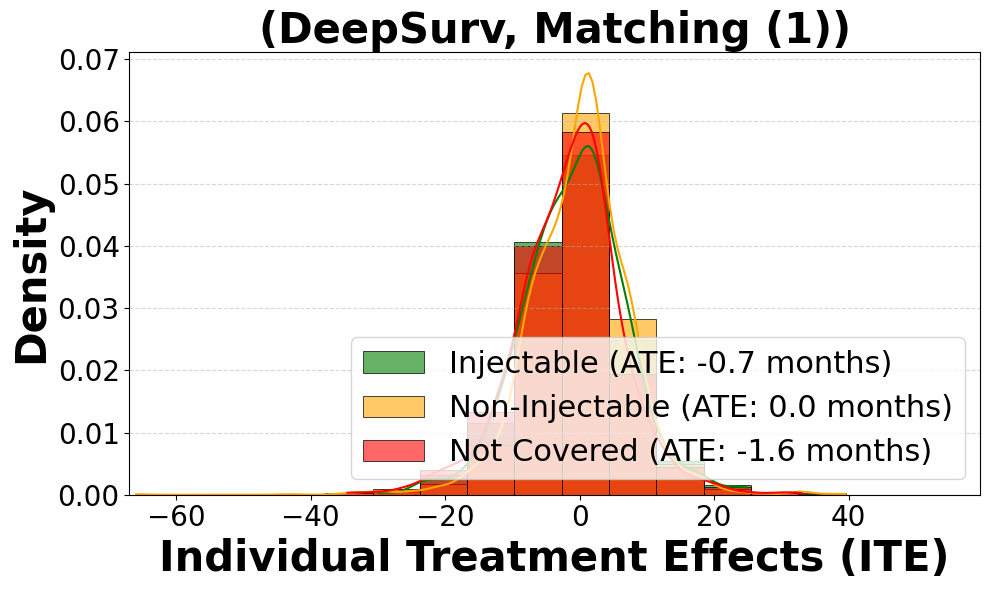

Meta-learner: Matching (5)


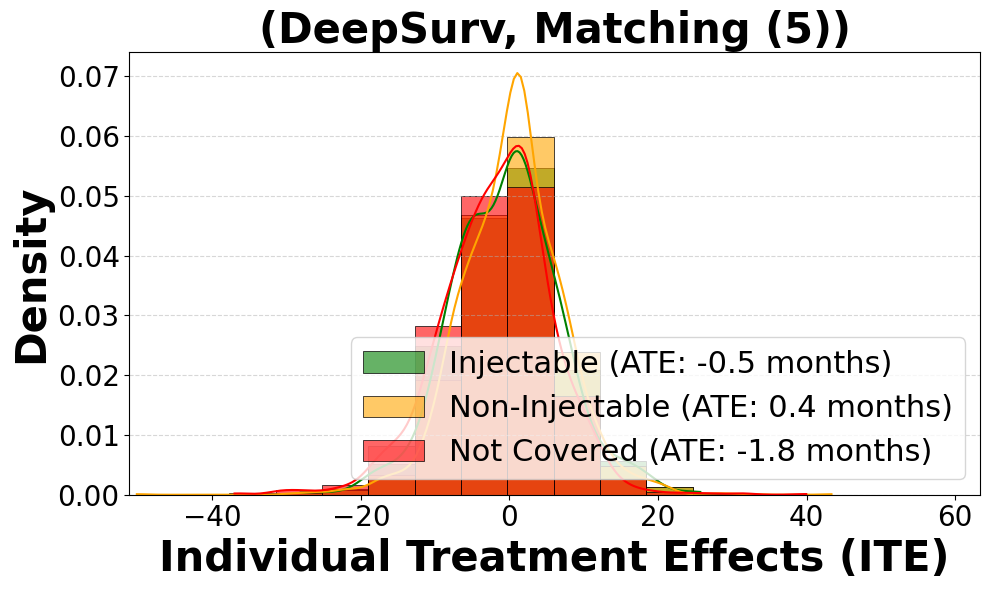

Survival Model: CausalSurvivalForest
Meta-learner: Causal Survival Forest


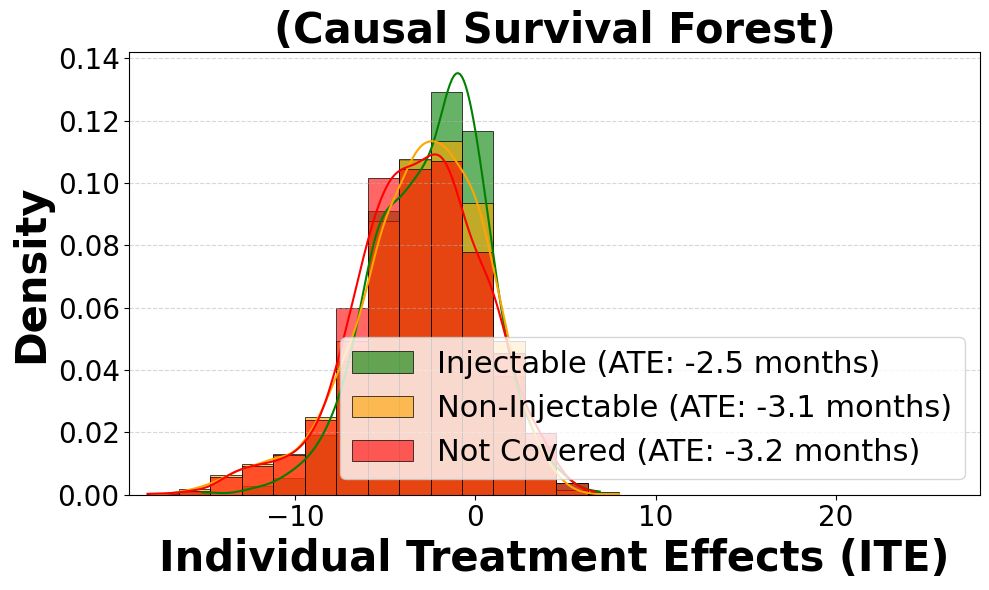

In [165]:
ax_locations = ['lower right', 'lower right', 'lower right', 'lower right']
# Example usage for evaluations
time_snapshot = 3
key = 1
num_bins = 15
plot_counter = 0
for survival_model_name in individual_treatment_effect_per_time_snapshot[time_snapshot].keys():
    if survival_model_name == "DeepHit": 
        continue
    print(f"Survival Model: {survival_model_name}")

    for meta_learner in individual_treatment_effect_per_time_snapshot[time_snapshot][survival_model_name].keys():
        print(f"Meta-learner: {meta_learner}")

        plot_counter += 1
        meta_learner_name = 'Causal Survival Forest' if survival_model_name == 'CausalSurvivalForest' else meta_learner

        fig, ax = plt.subplots(figsize=(10, 6))
        plot_ITE_injectable_type_paper_ready(ax, individual_treatment_effect_per_time_snapshot[time_snapshot][survival_model_name][meta_learner_name], 
                                            survival_model_name, meta_learner_name, key, num_bins)
        
        # Adjust legend
        ax.legend(fontsize=22, loc=ax_locations[plot_counter%len(ax_locations)])
        
        plt.tight_layout()
        plt.savefig(f"ITE_{survival_model_name}_{meta_learner_name}_injectable_type.pdf")
        plt.show()

        plot_counter += 1

Survival Model: CoxPH


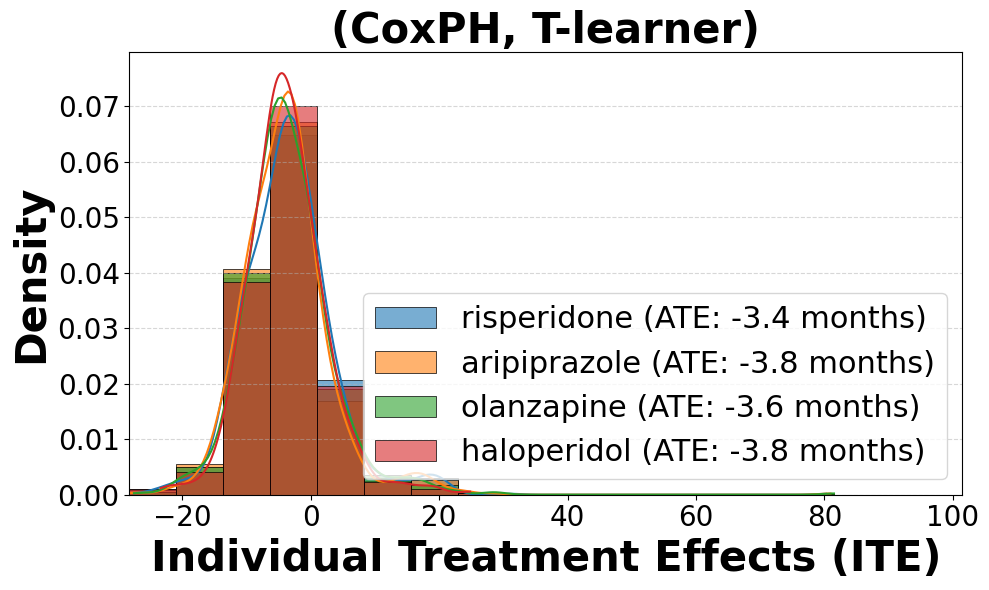

Survival Model: RandomSurvivalForest


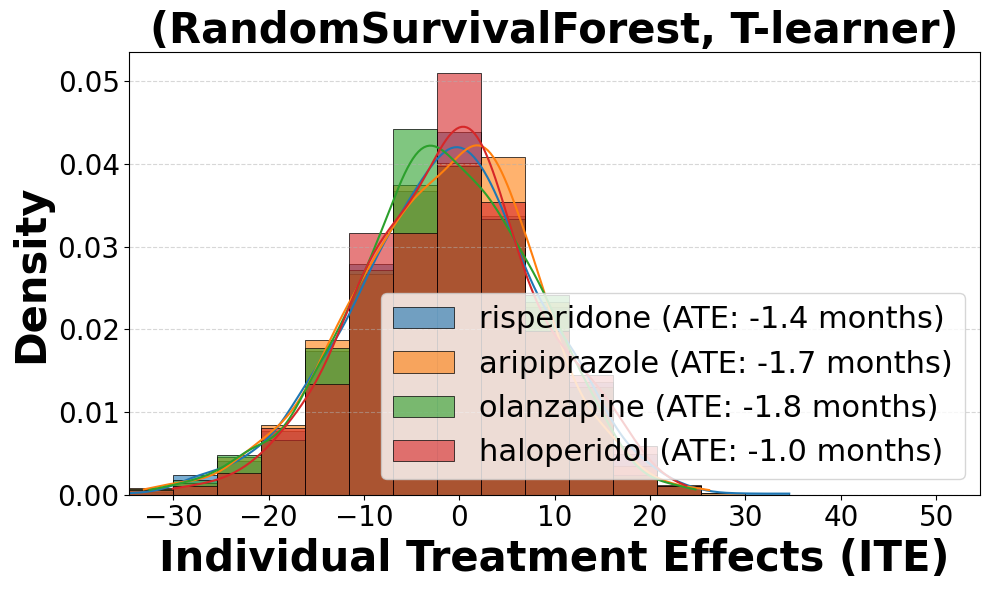

Survival Model: DeepSurv


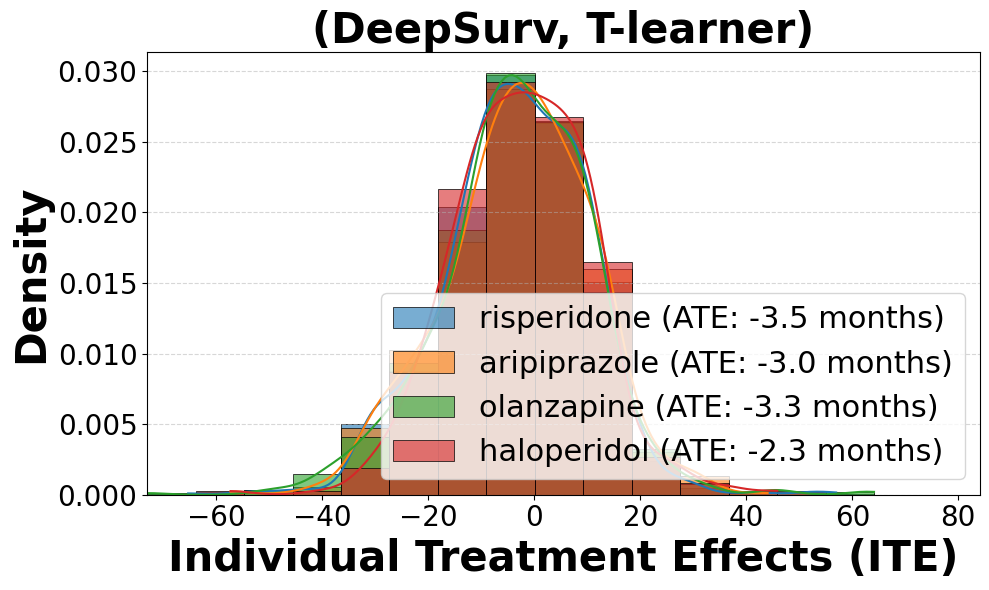

Survival Model: CausalSurvivalForest


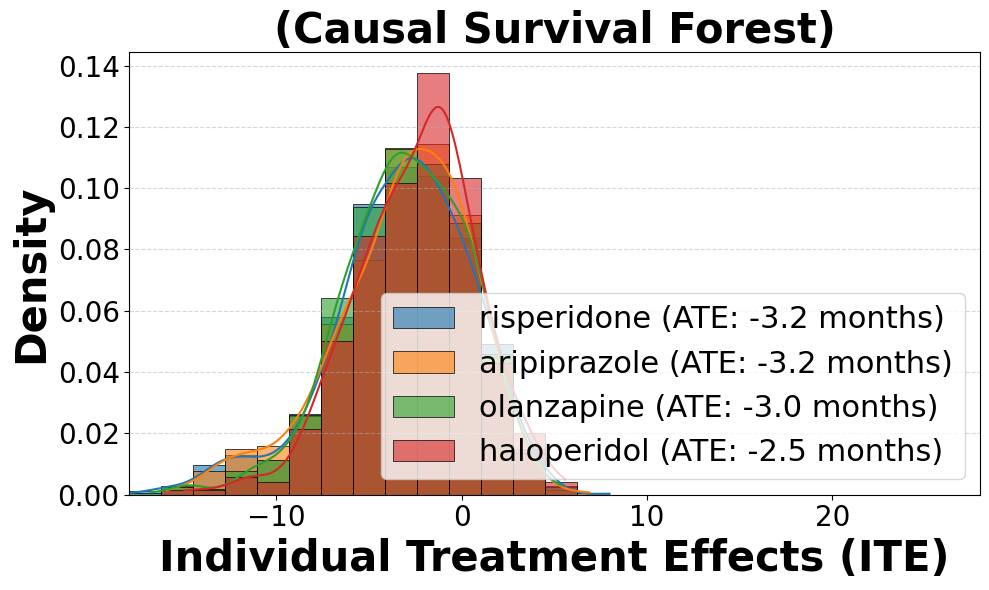

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_ITE_med_type_paper_ready(ax, ite_meta_learner, survival_model_name, meta_learner_name, top_k_medications=5, num_bins=15):
    """
    Creates paper-ready histograms for ITE distributions across different medication adherence groups with aligned bins.

    Args:
        ax (matplotlib.axes._subplots.AxesSubplot): Axis to plot on.
        ite_meta_learner (dict): Dictionary containing ITE and post-hoc data.
        survival_model_name (str): Name of the survival model.
        meta_learner_name (str): Name of the meta-learner.
    """
    ite_list = ite_meta_learner['ITE']
    post_hoc_list = ite_meta_learner['post_hoc']['covered_by']  # List of lists of medications

    # Flatten the list of lists and count medication frequencies
    flat_medications = [med for med_list in post_hoc_list for med in med_list[-1]]
    medication_counts = Counter(flat_medications)

    # Get the top k most common medications
    top_medications = [med for med, _ in medication_counts.most_common(top_k_medications)]

    # Prepare data for plotting
    medication_groups = []
    labels = []
    colors = sns.color_palette("tab10", len(top_medications))  # Assign colors dynamically

    for med, color in zip(top_medications, colors):
        # Filter ITE values for patients using the current medication
        ite_for_med = [ite_list[i] for i, med_list in enumerate(post_hoc_list) if med in med_list[-1]]
        medication_groups.append((ite_for_med, med, color))
        labels.append(f"{med[:12]} (ATE: {np.mean(ite_for_med):.1f} months)")

    # Compute aligned bin edges
    all_data = np.concatenate([group[0] for group in medication_groups])
    bin_edges = np.histogram_bin_edges(all_data, bins=num_bins)

    # Plot histograms for each medication
    for (group, _, color), label in zip(medication_groups, labels):
        sns.histplot(
            group, bins=bin_edges, kde=True, stat="density",
            ax=ax, label=label, color=color, alpha=0.6, edgecolor="black", linewidth=0.5
        )

    # Set axis limits
    ax.set_xlim(bin_edges[0], bin_edges[-1])
    ax.set_ylim(0, None)

    # Customize axis labels and title
    ax.set_xlabel("Individual Treatment Effects (ITE)", fontsize=30, fontweight='bold')
    ax.set_ylabel("Density", fontsize=30, fontweight='bold')
    if meta_learner_name == 'Causal Survival Forest':
        title_str = '(Causal Survival Forest)'
    else:
        title_str = f"({survival_model_name}, {meta_learner_name})"
    ax.set_title(f"{title_str}", fontsize=30, fontweight='bold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]+20)

    # Add gridlines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.5)

ax_locations = ['lower right', 'lower right', 'lower right', 'lower right']
# Example usage for evaluations
time_snapshot = 3
top_k_medications = 4
num_bins = 15

plot_counter = 0
for survival_model_name in individual_treatment_effect_per_time_snapshot[time_snapshot].keys():
    if survival_model_name == "DeepHit": 
        continue
    print(f"Survival Model: {survival_model_name}")
    meta_learner_name = 'Causal Survival Forest' if survival_model_name == 'CausalSurvivalForest' else 'T-learner'

    fig, ax = plt.subplots(figsize=(10, 6))
    plot_ITE_med_type_paper_ready(
        ax, individual_treatment_effect_per_time_snapshot[time_snapshot][survival_model_name][meta_learner_name], 
        survival_model_name, meta_learner_name, top_k_medications, num_bins
    )

    # Adjust legend
    ax.legend(fontsize=22, loc=ax_locations[plot_counter%len(ax_locations)])

    plt.tight_layout()
    plt.savefig(f"ITE_{survival_model_name}_{meta_learner_name}_med_type.pdf", dpi=300)
    plt.show()

    plot_counter += 1

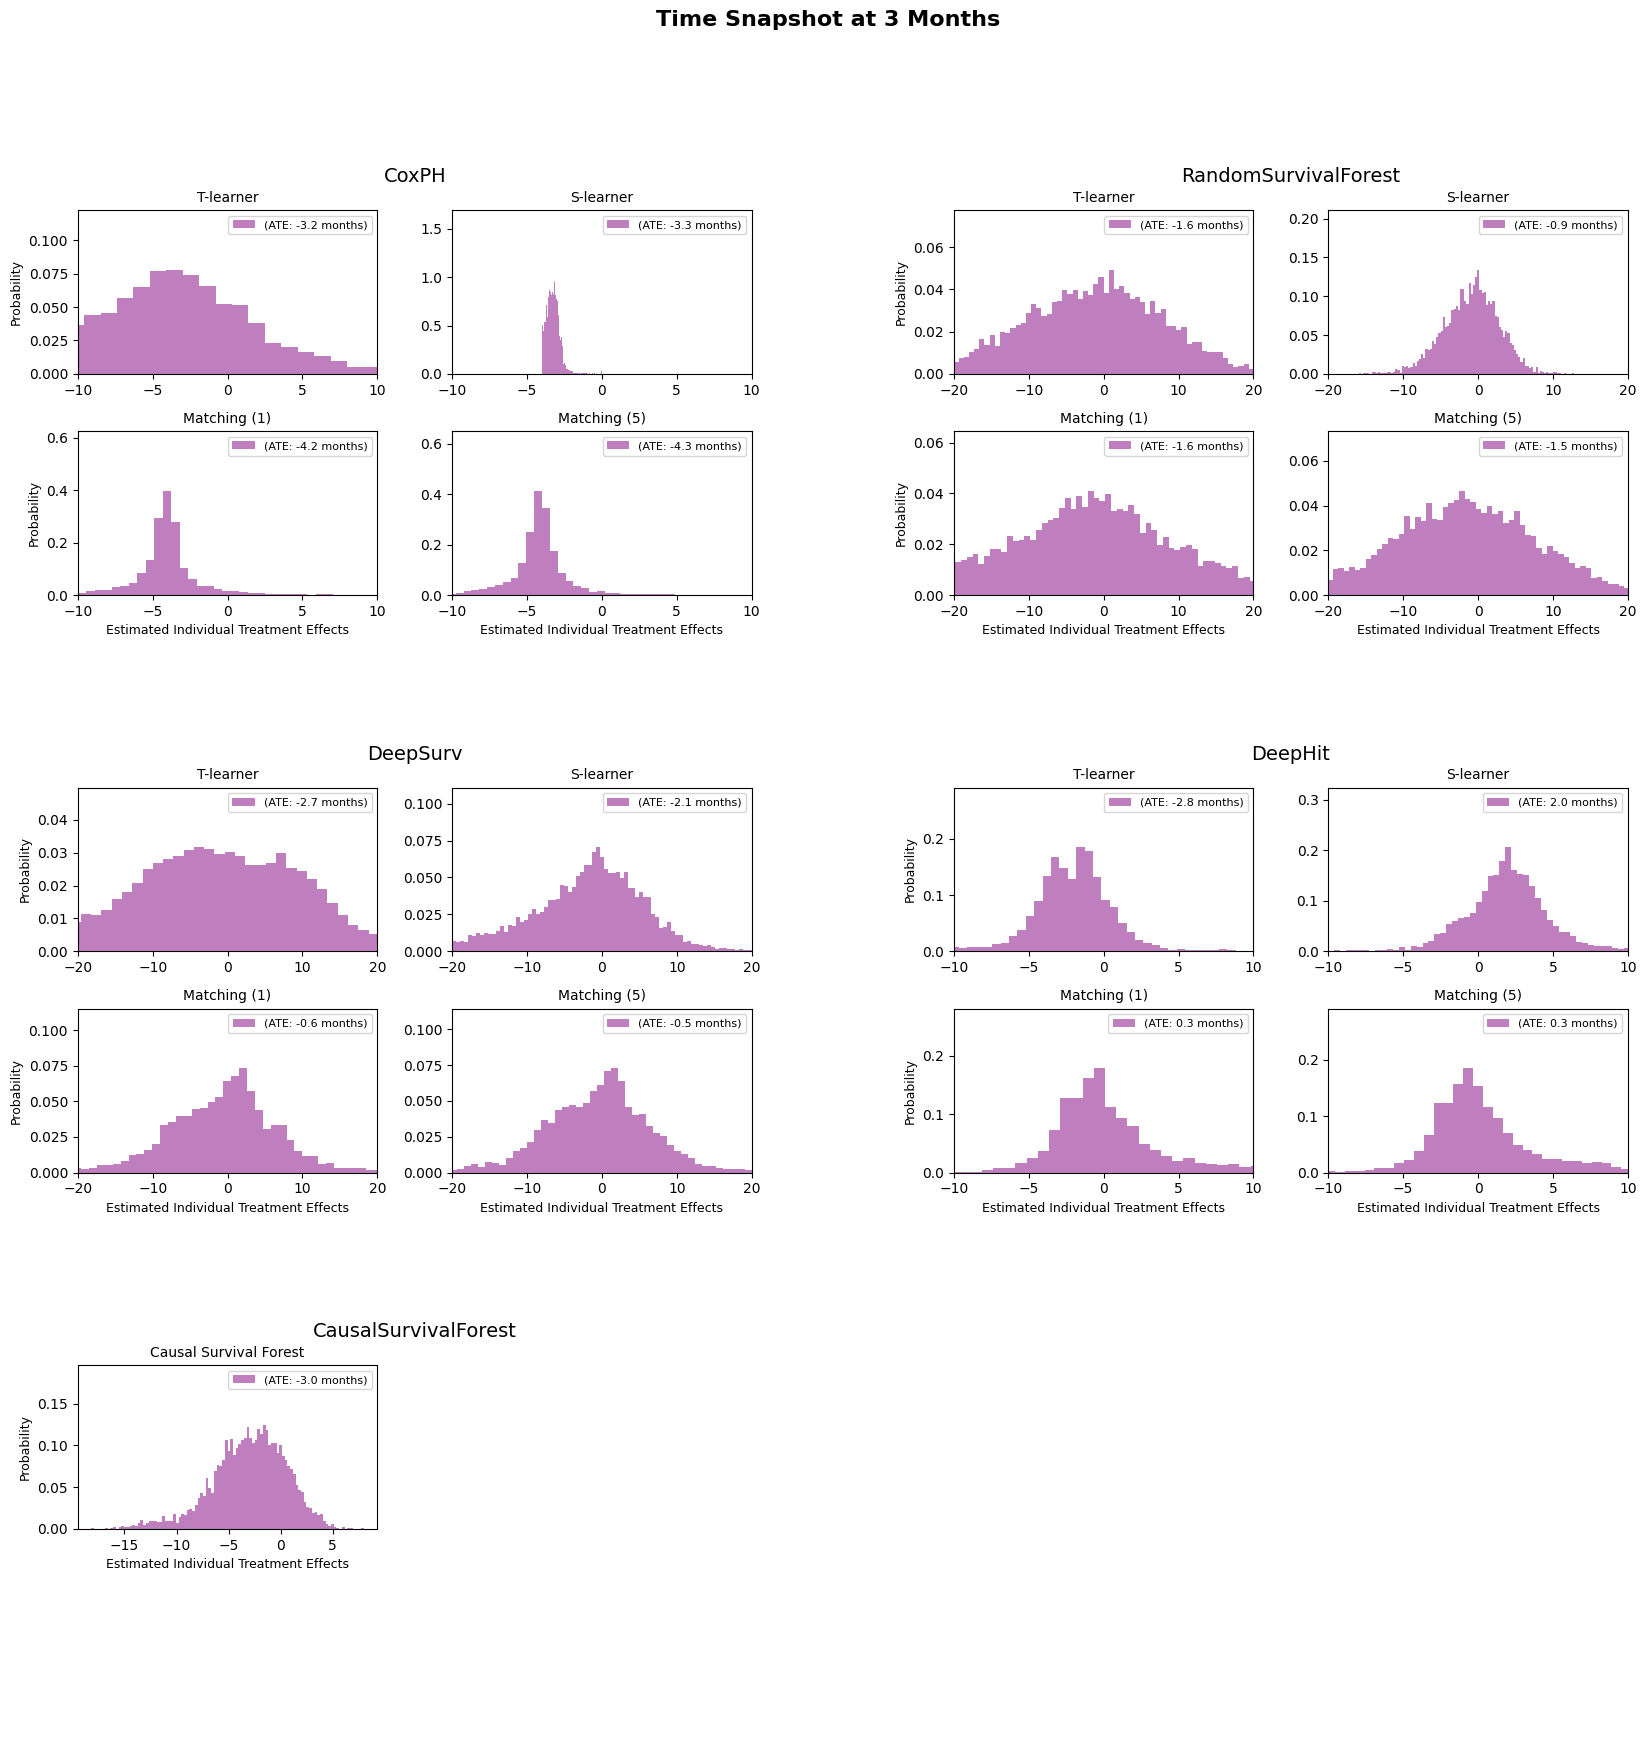

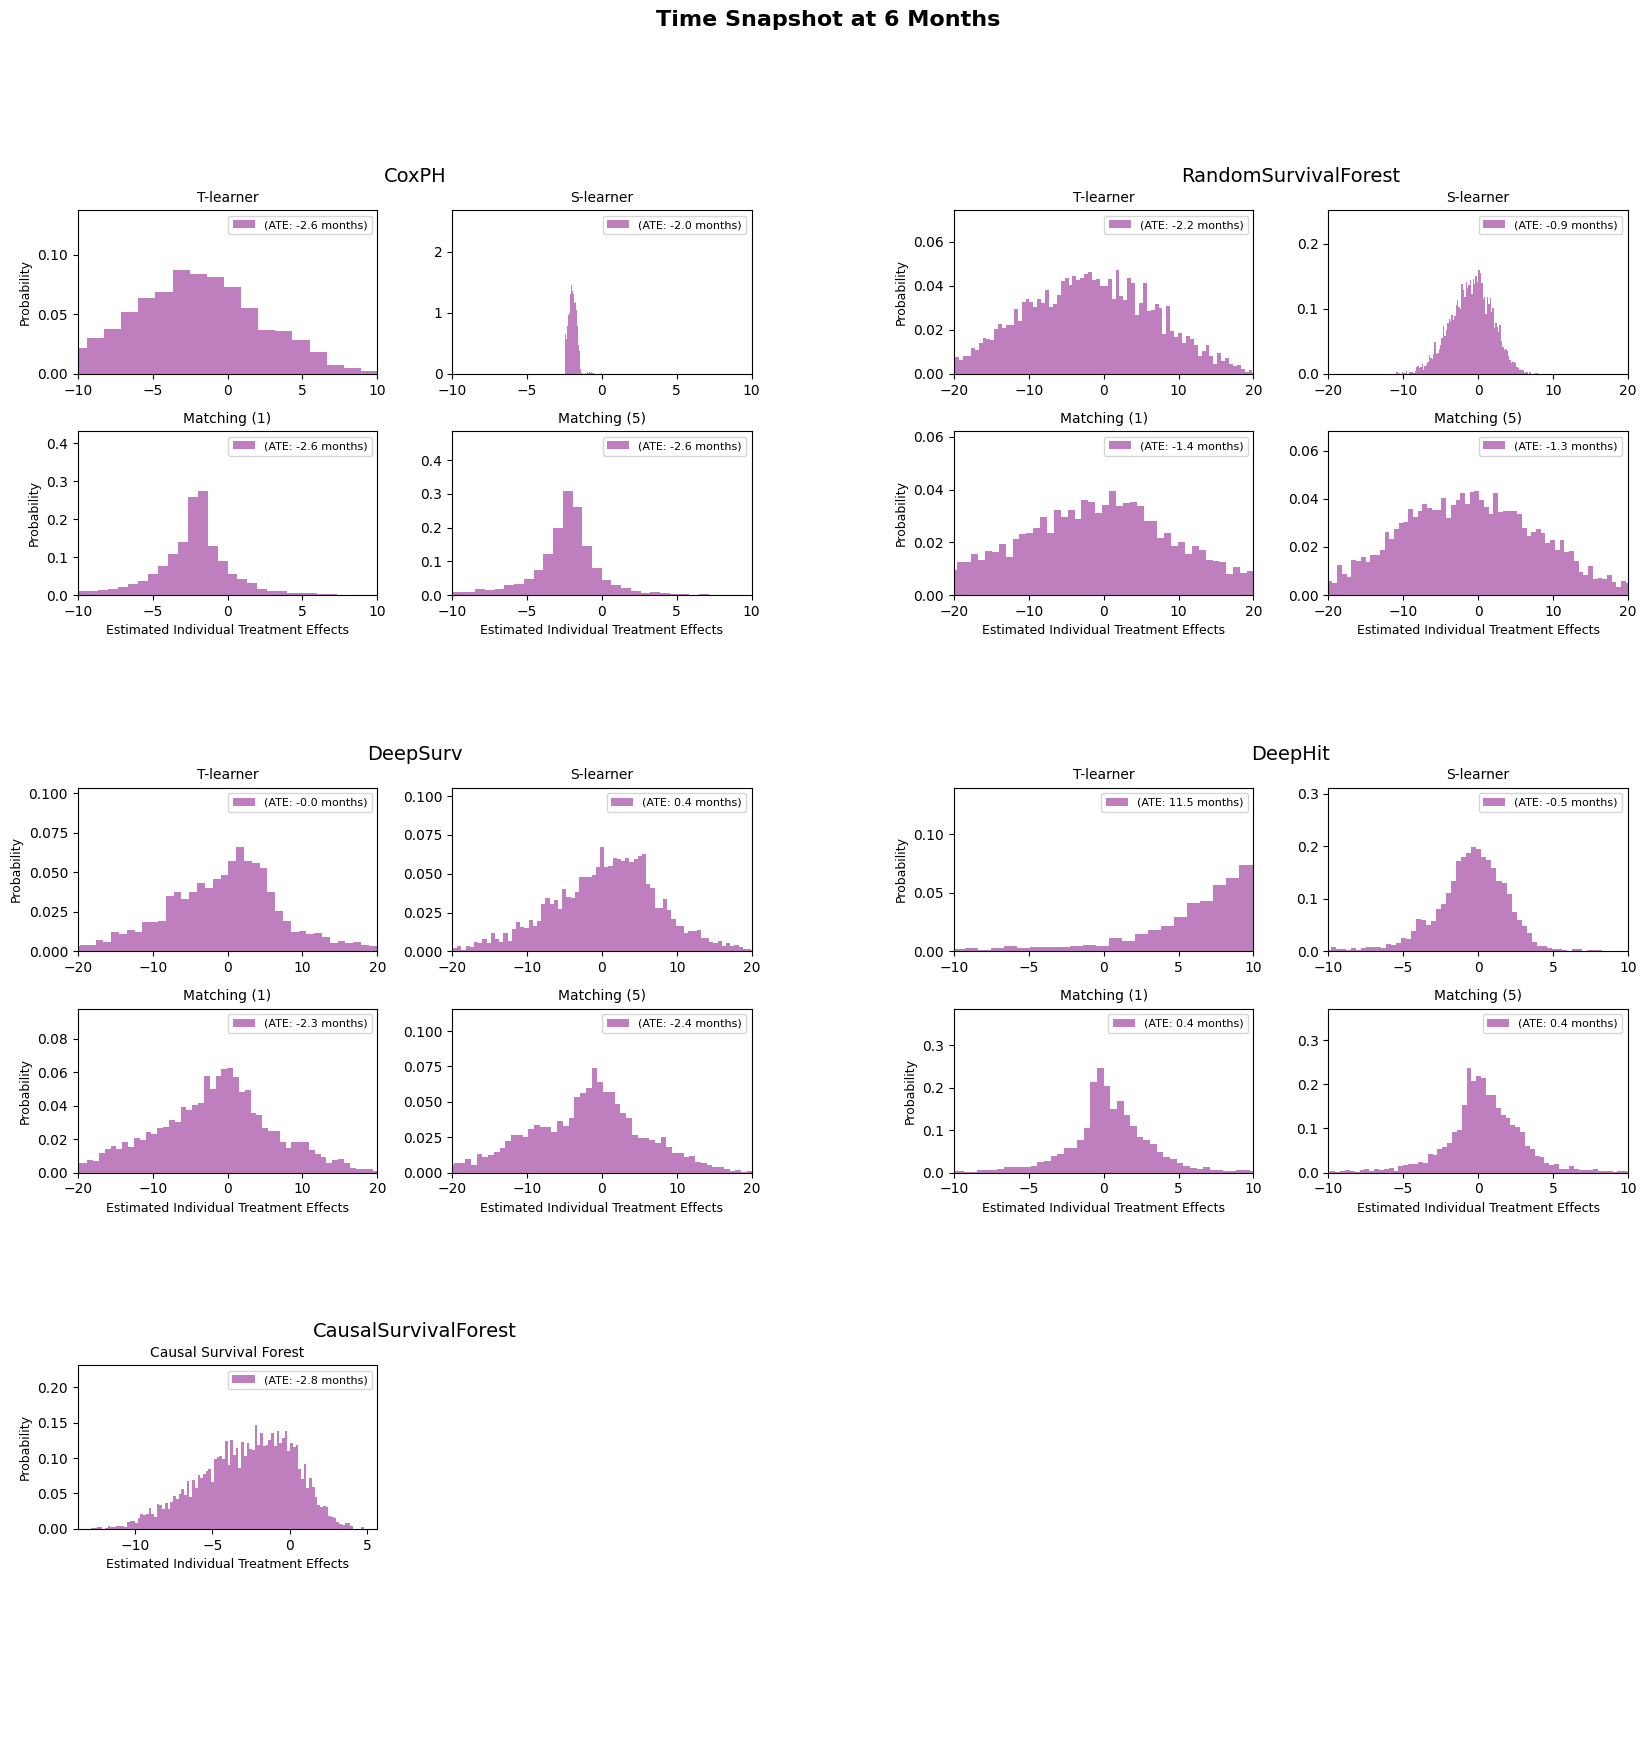

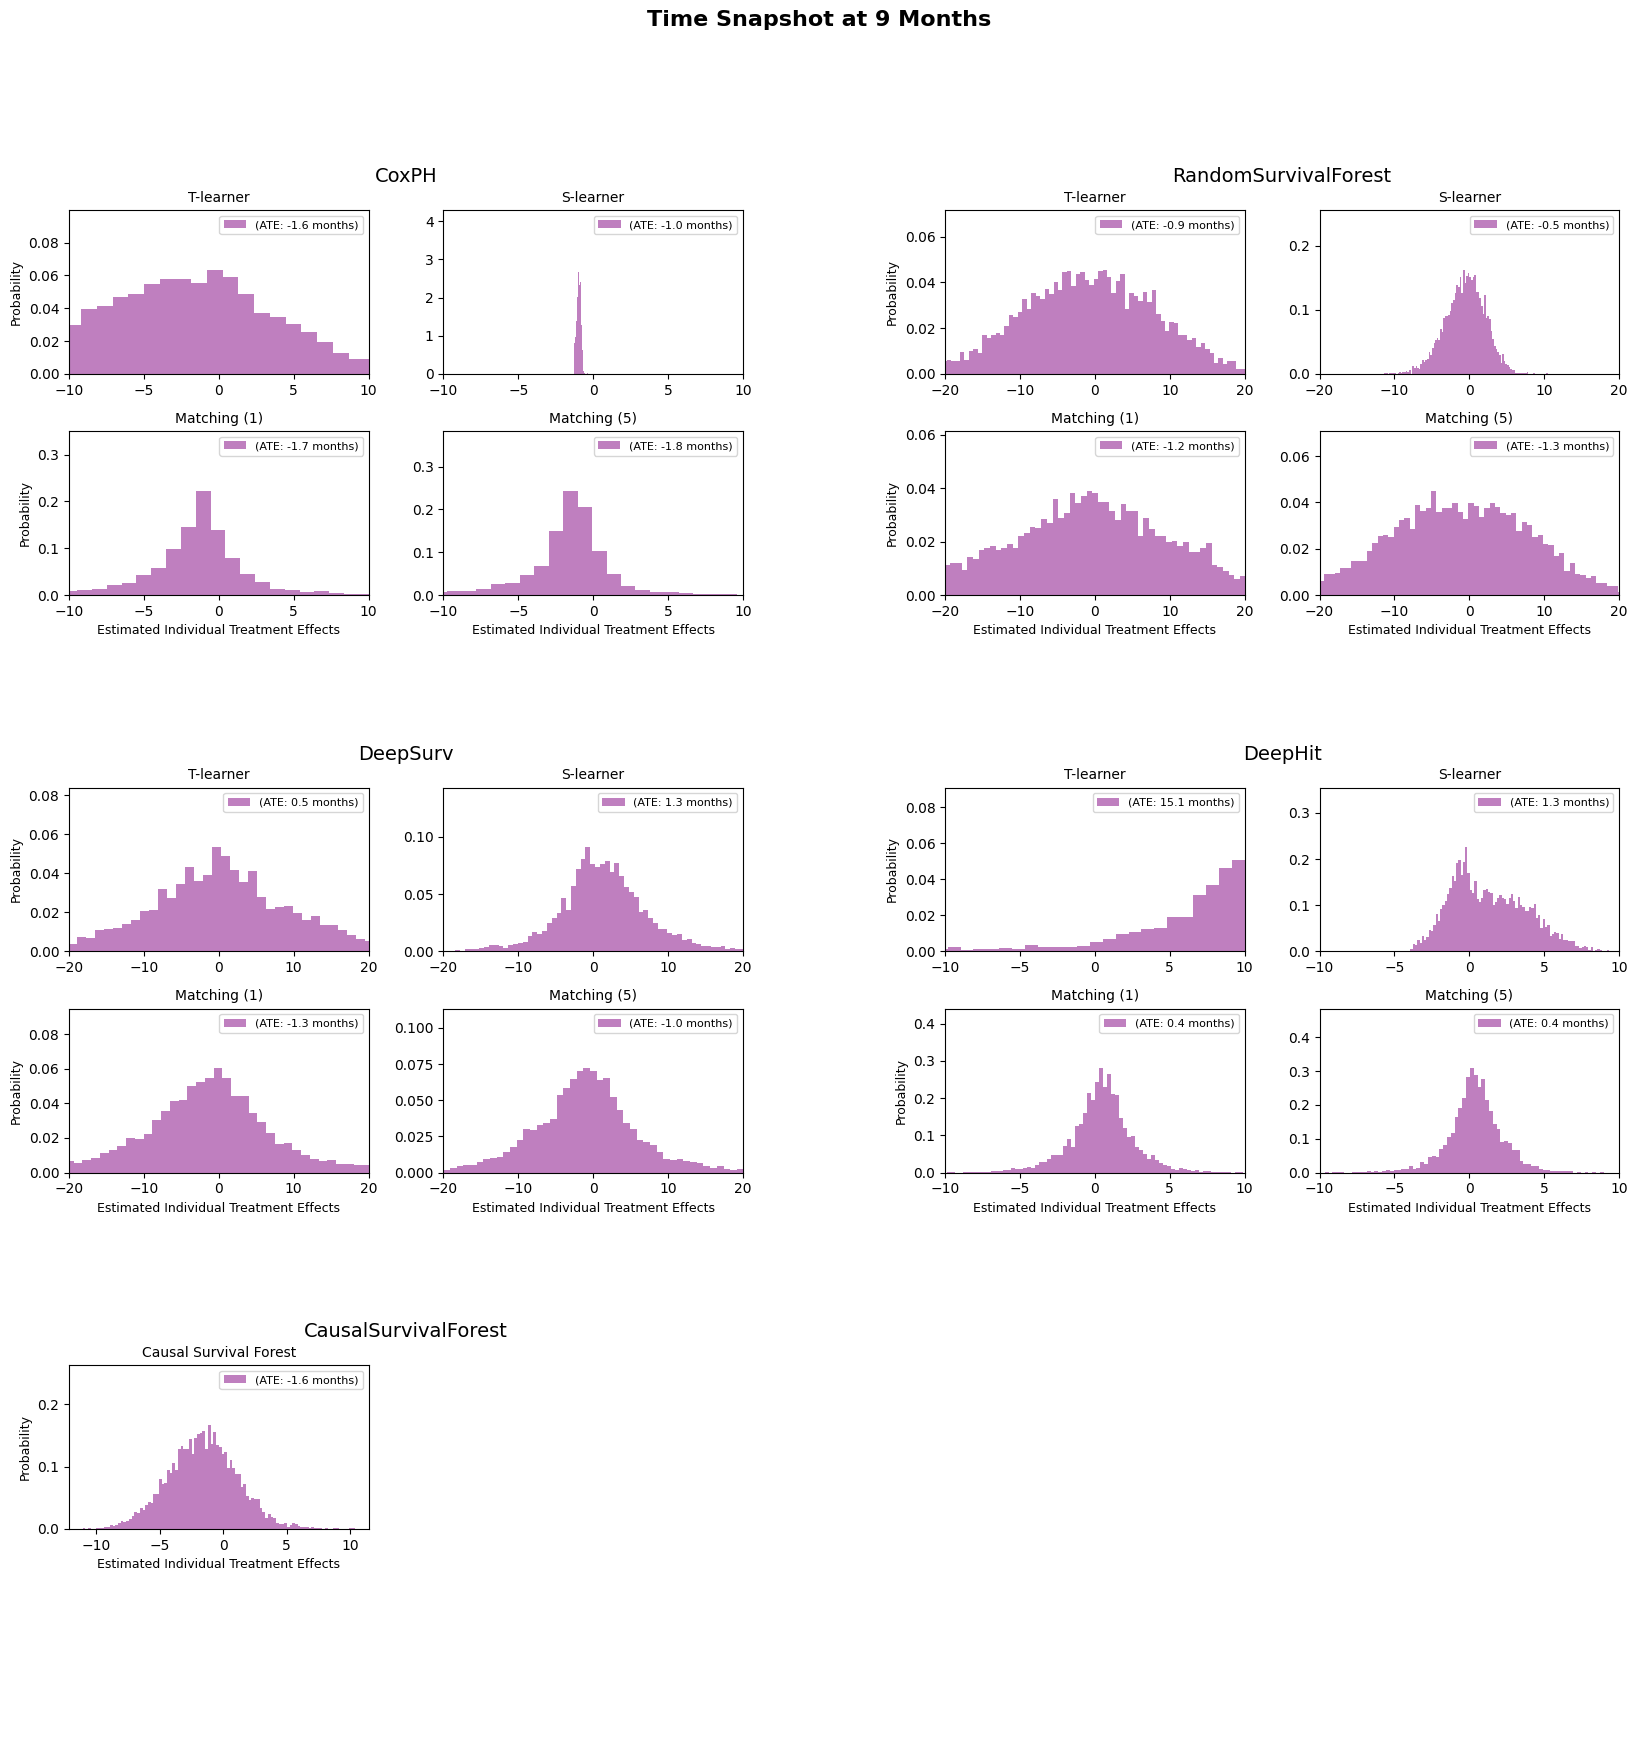

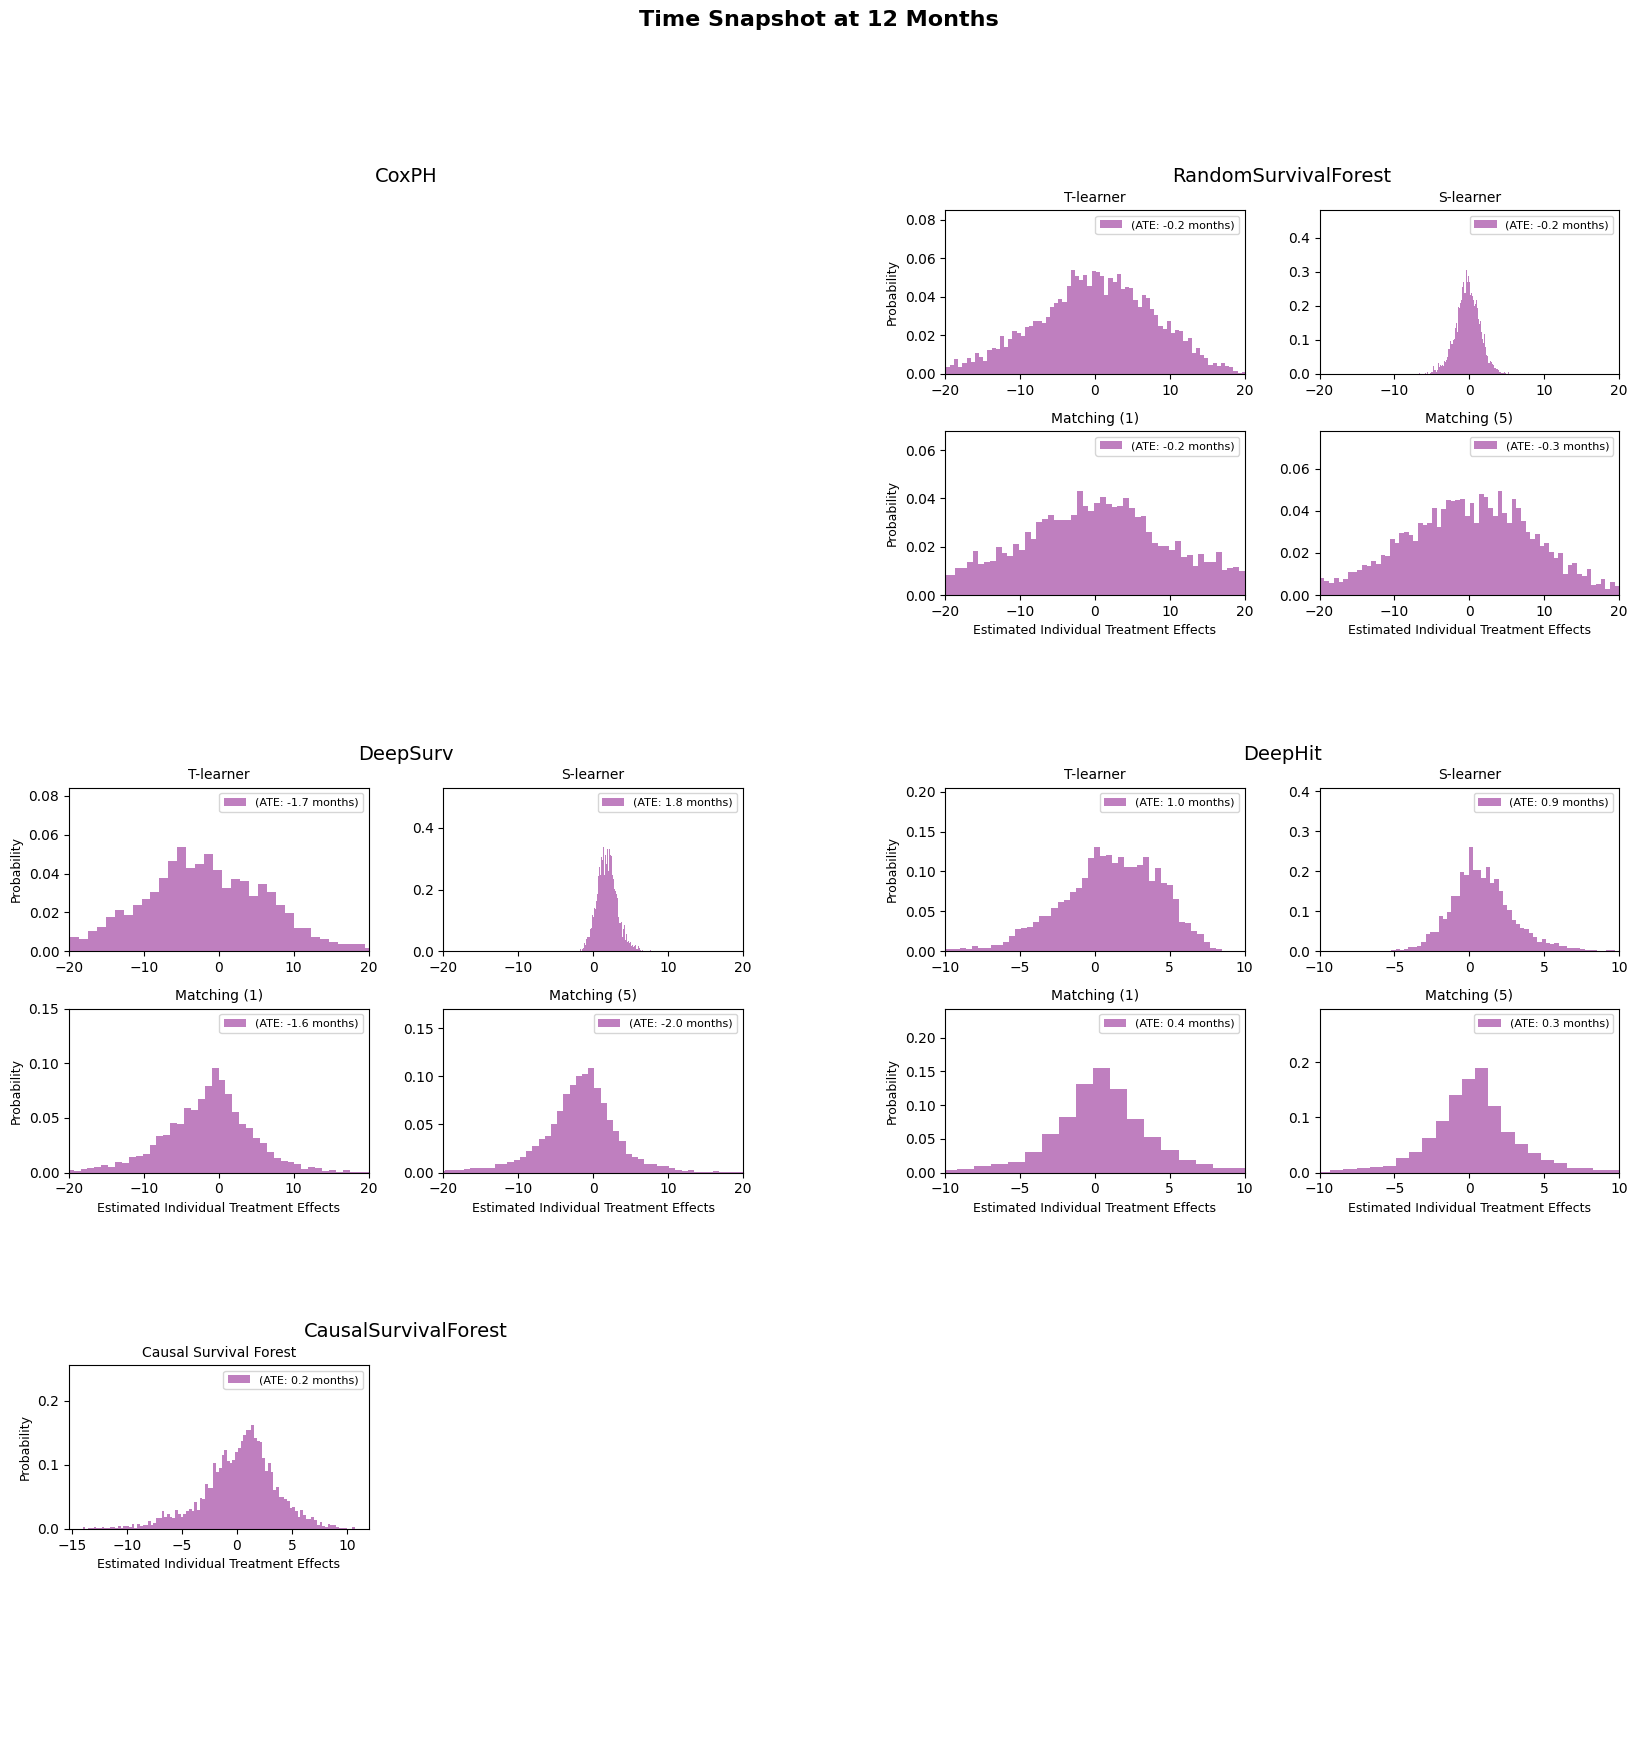

In [26]:
post_hoc_mode = None

for i, time_snapshot in enumerate(individual_treatment_effect_per_time_snapshot):

    plot_survival_analysis_results(individual_treatment_effect_per_time_snapshot[time_snapshot], 
                                   outer_grid_spacing_w=0.3, outer_grid_spacing_h=0.5,
                                   inner_grid_spacing_w=0.25, inner_grid_spacing_h=0.35,
                                   post_hoc_mode=post_hoc_mode, figure_title=f"Time Snapshot at {time_snapshot} Months")
    
    if i >= 3: break

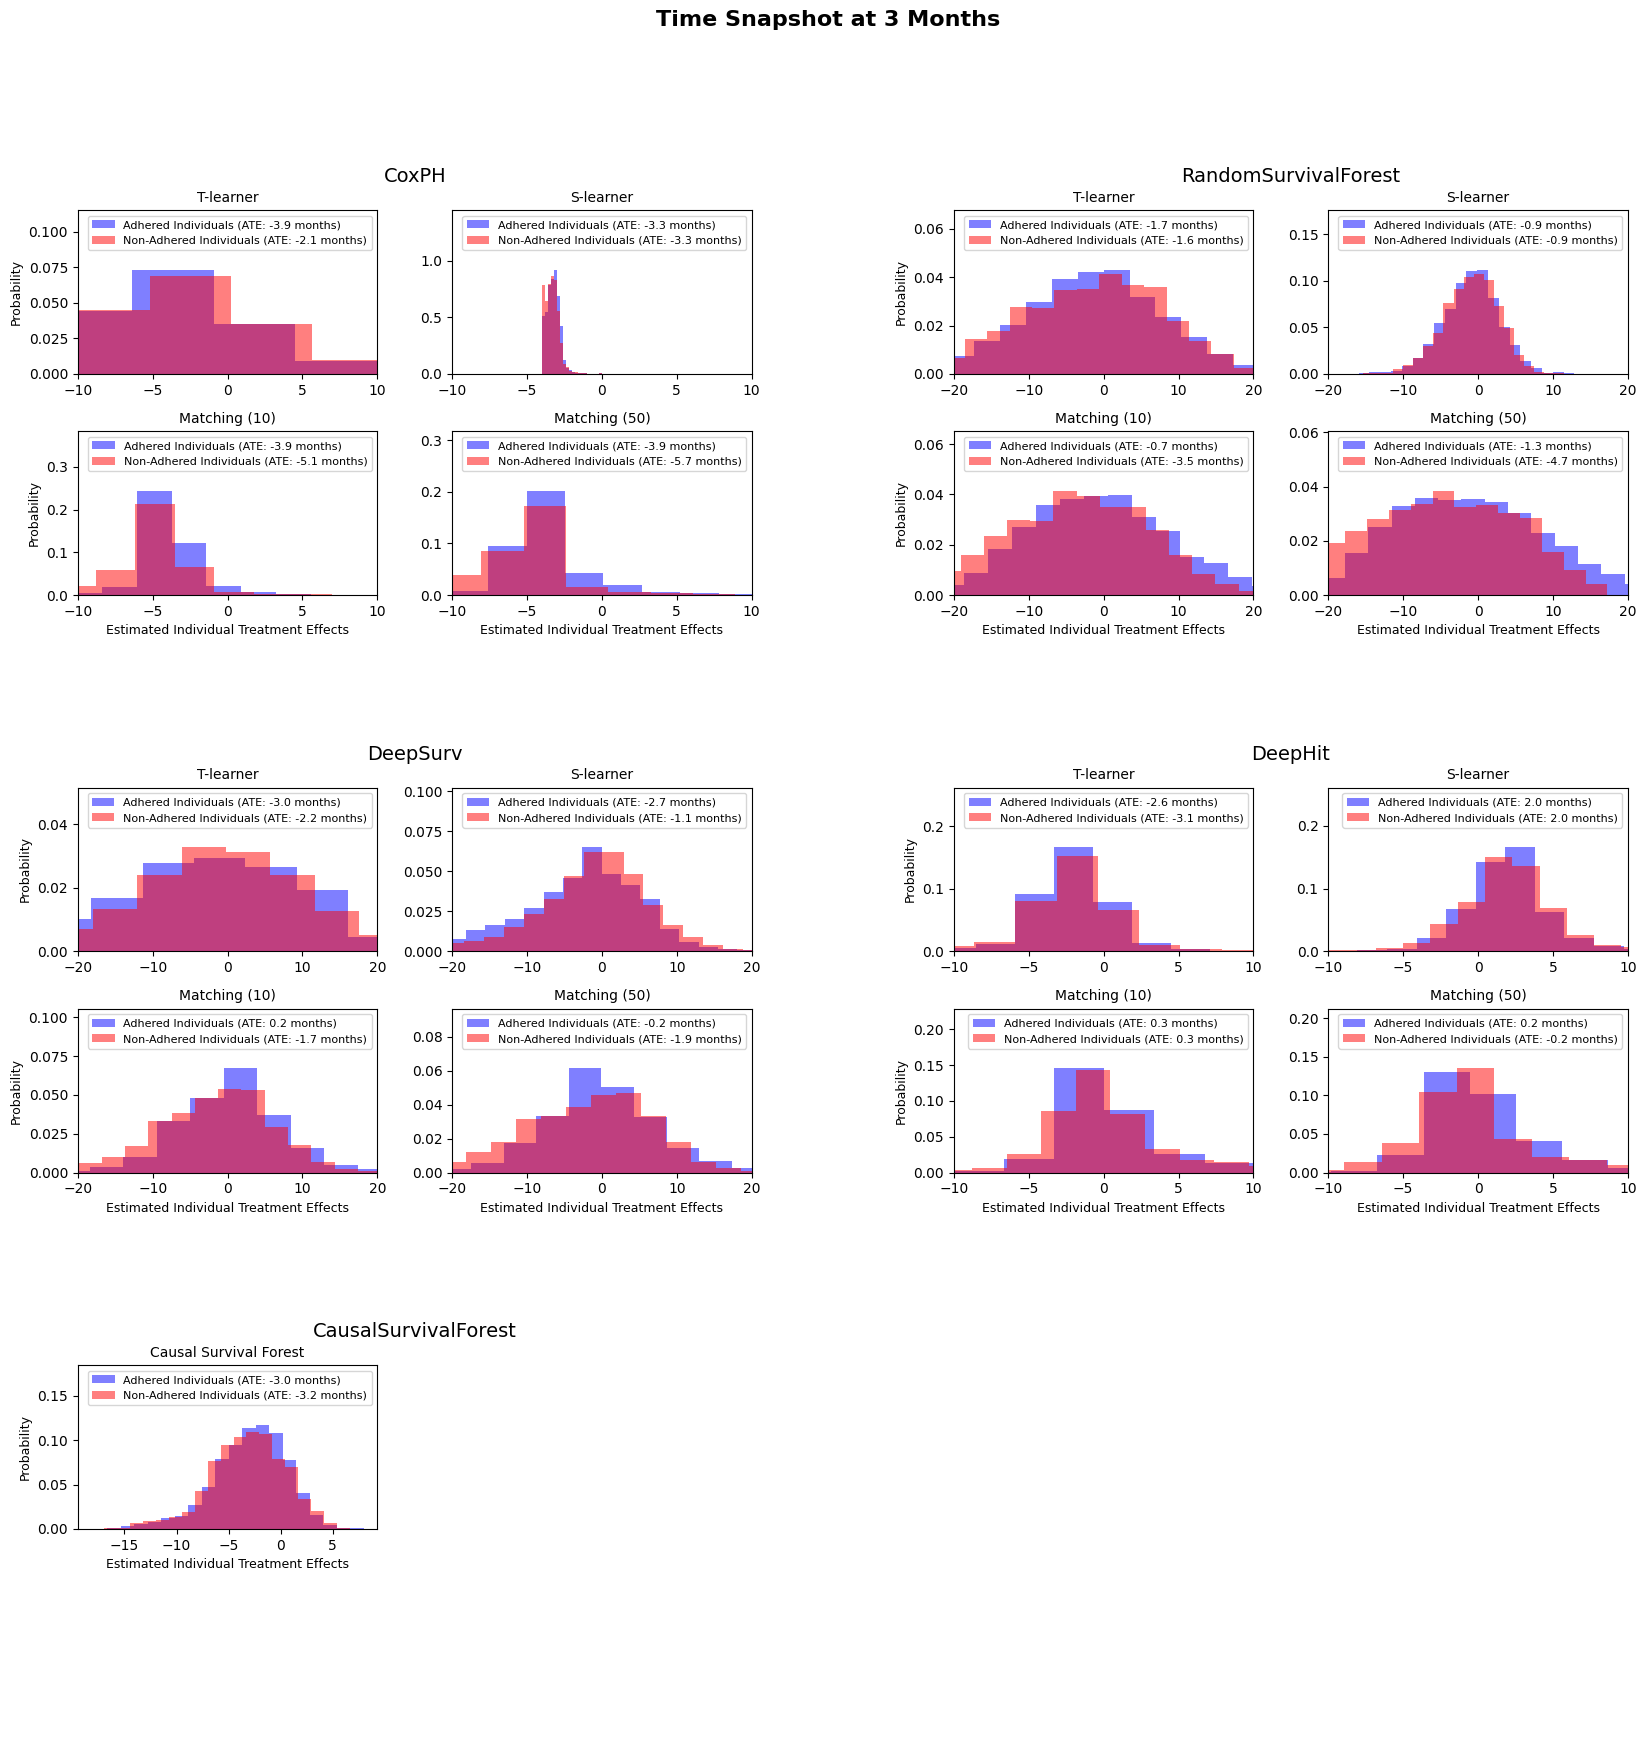

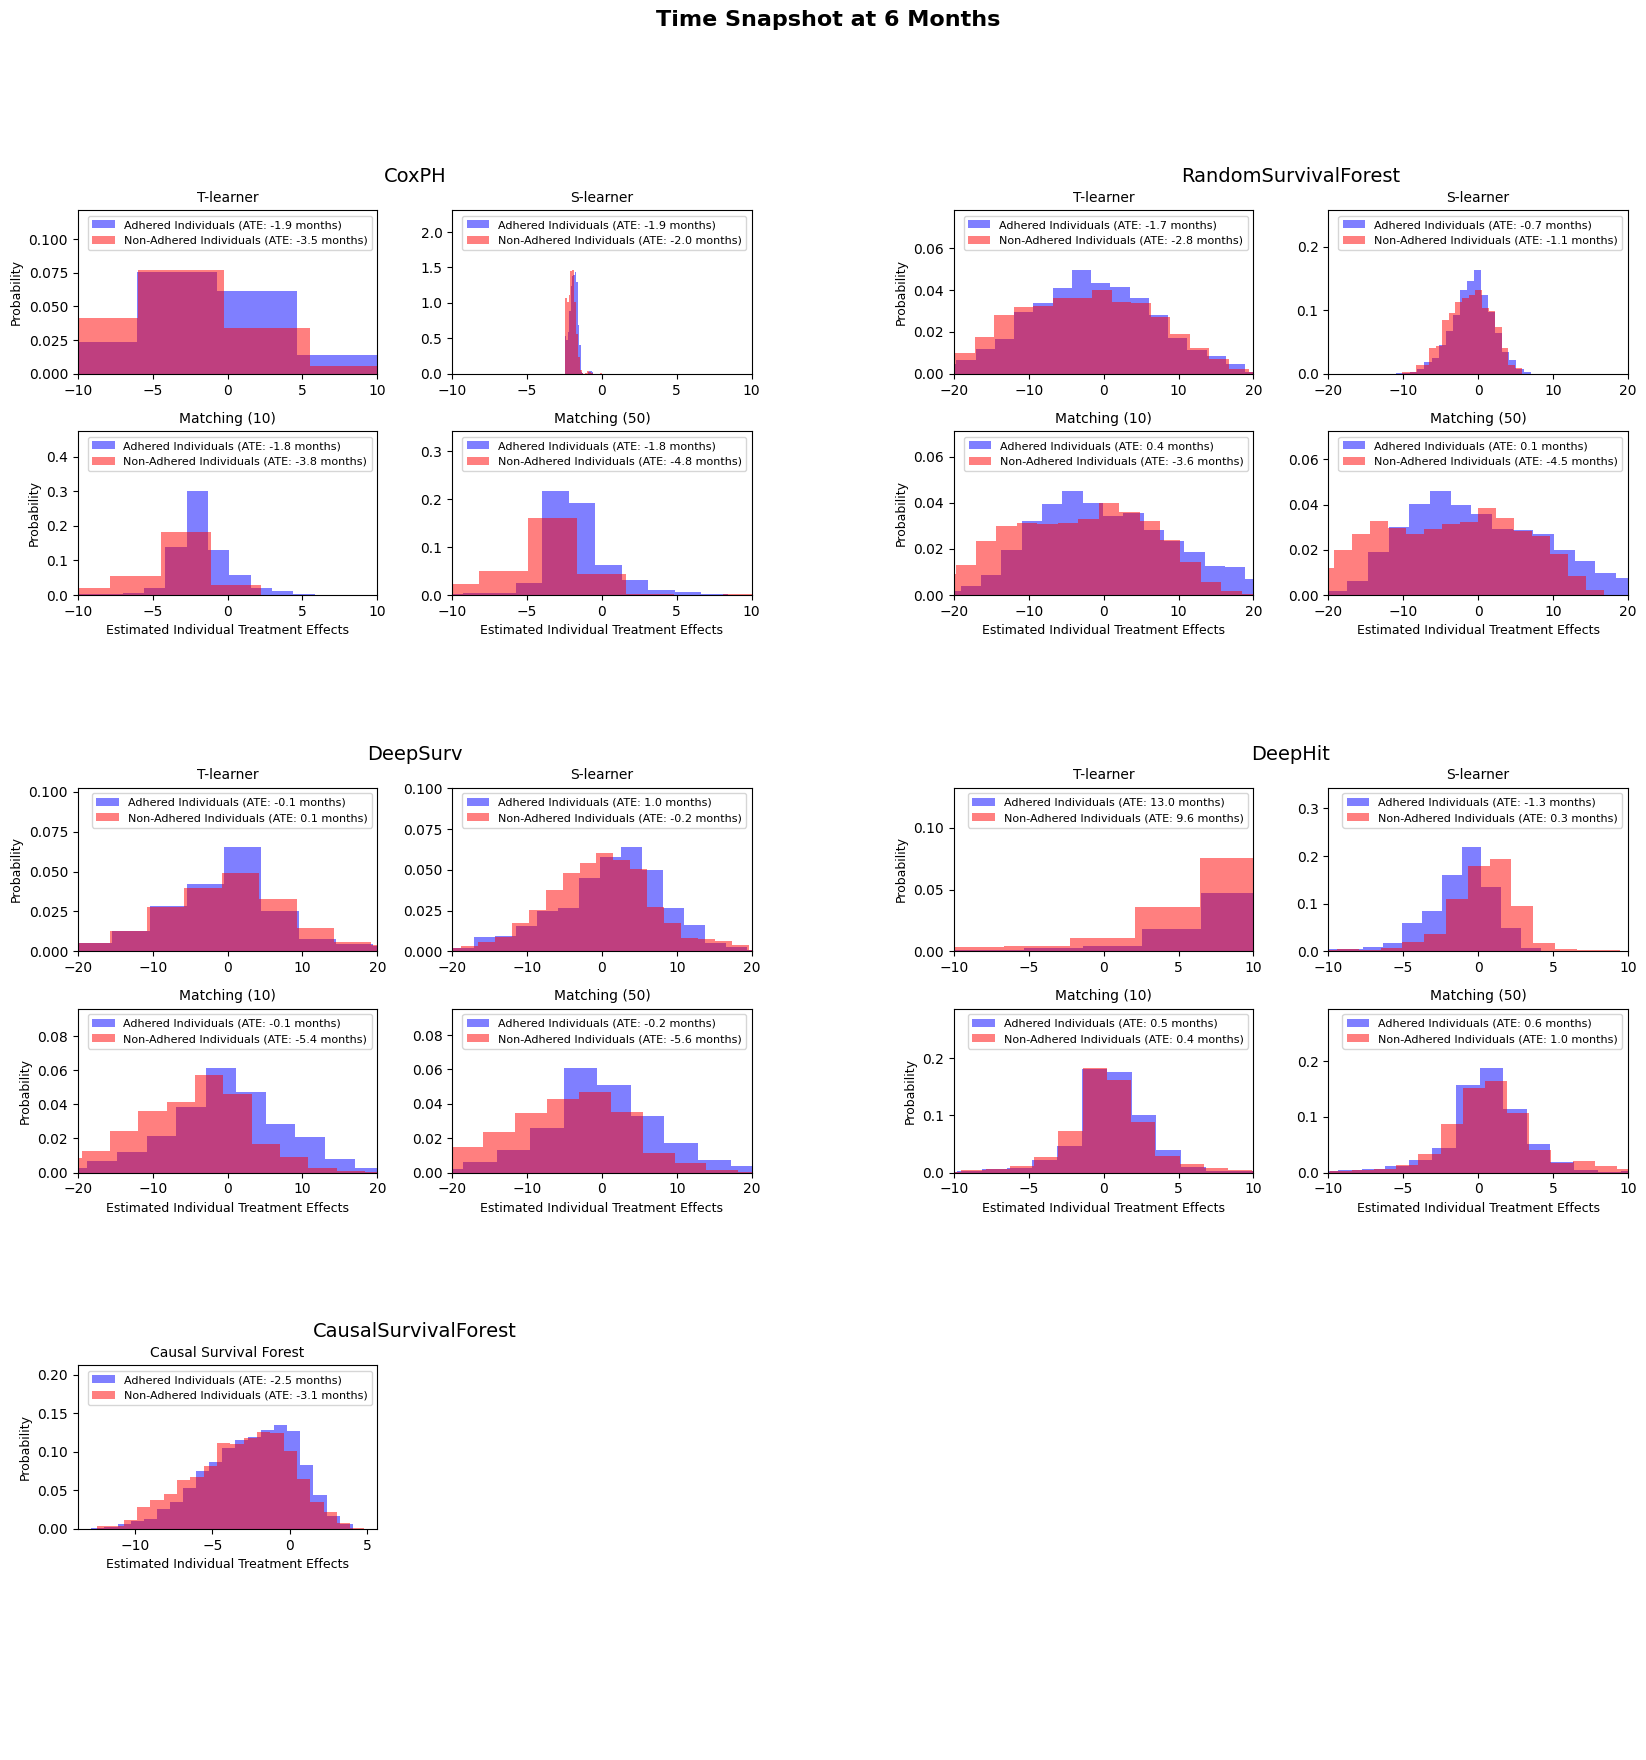

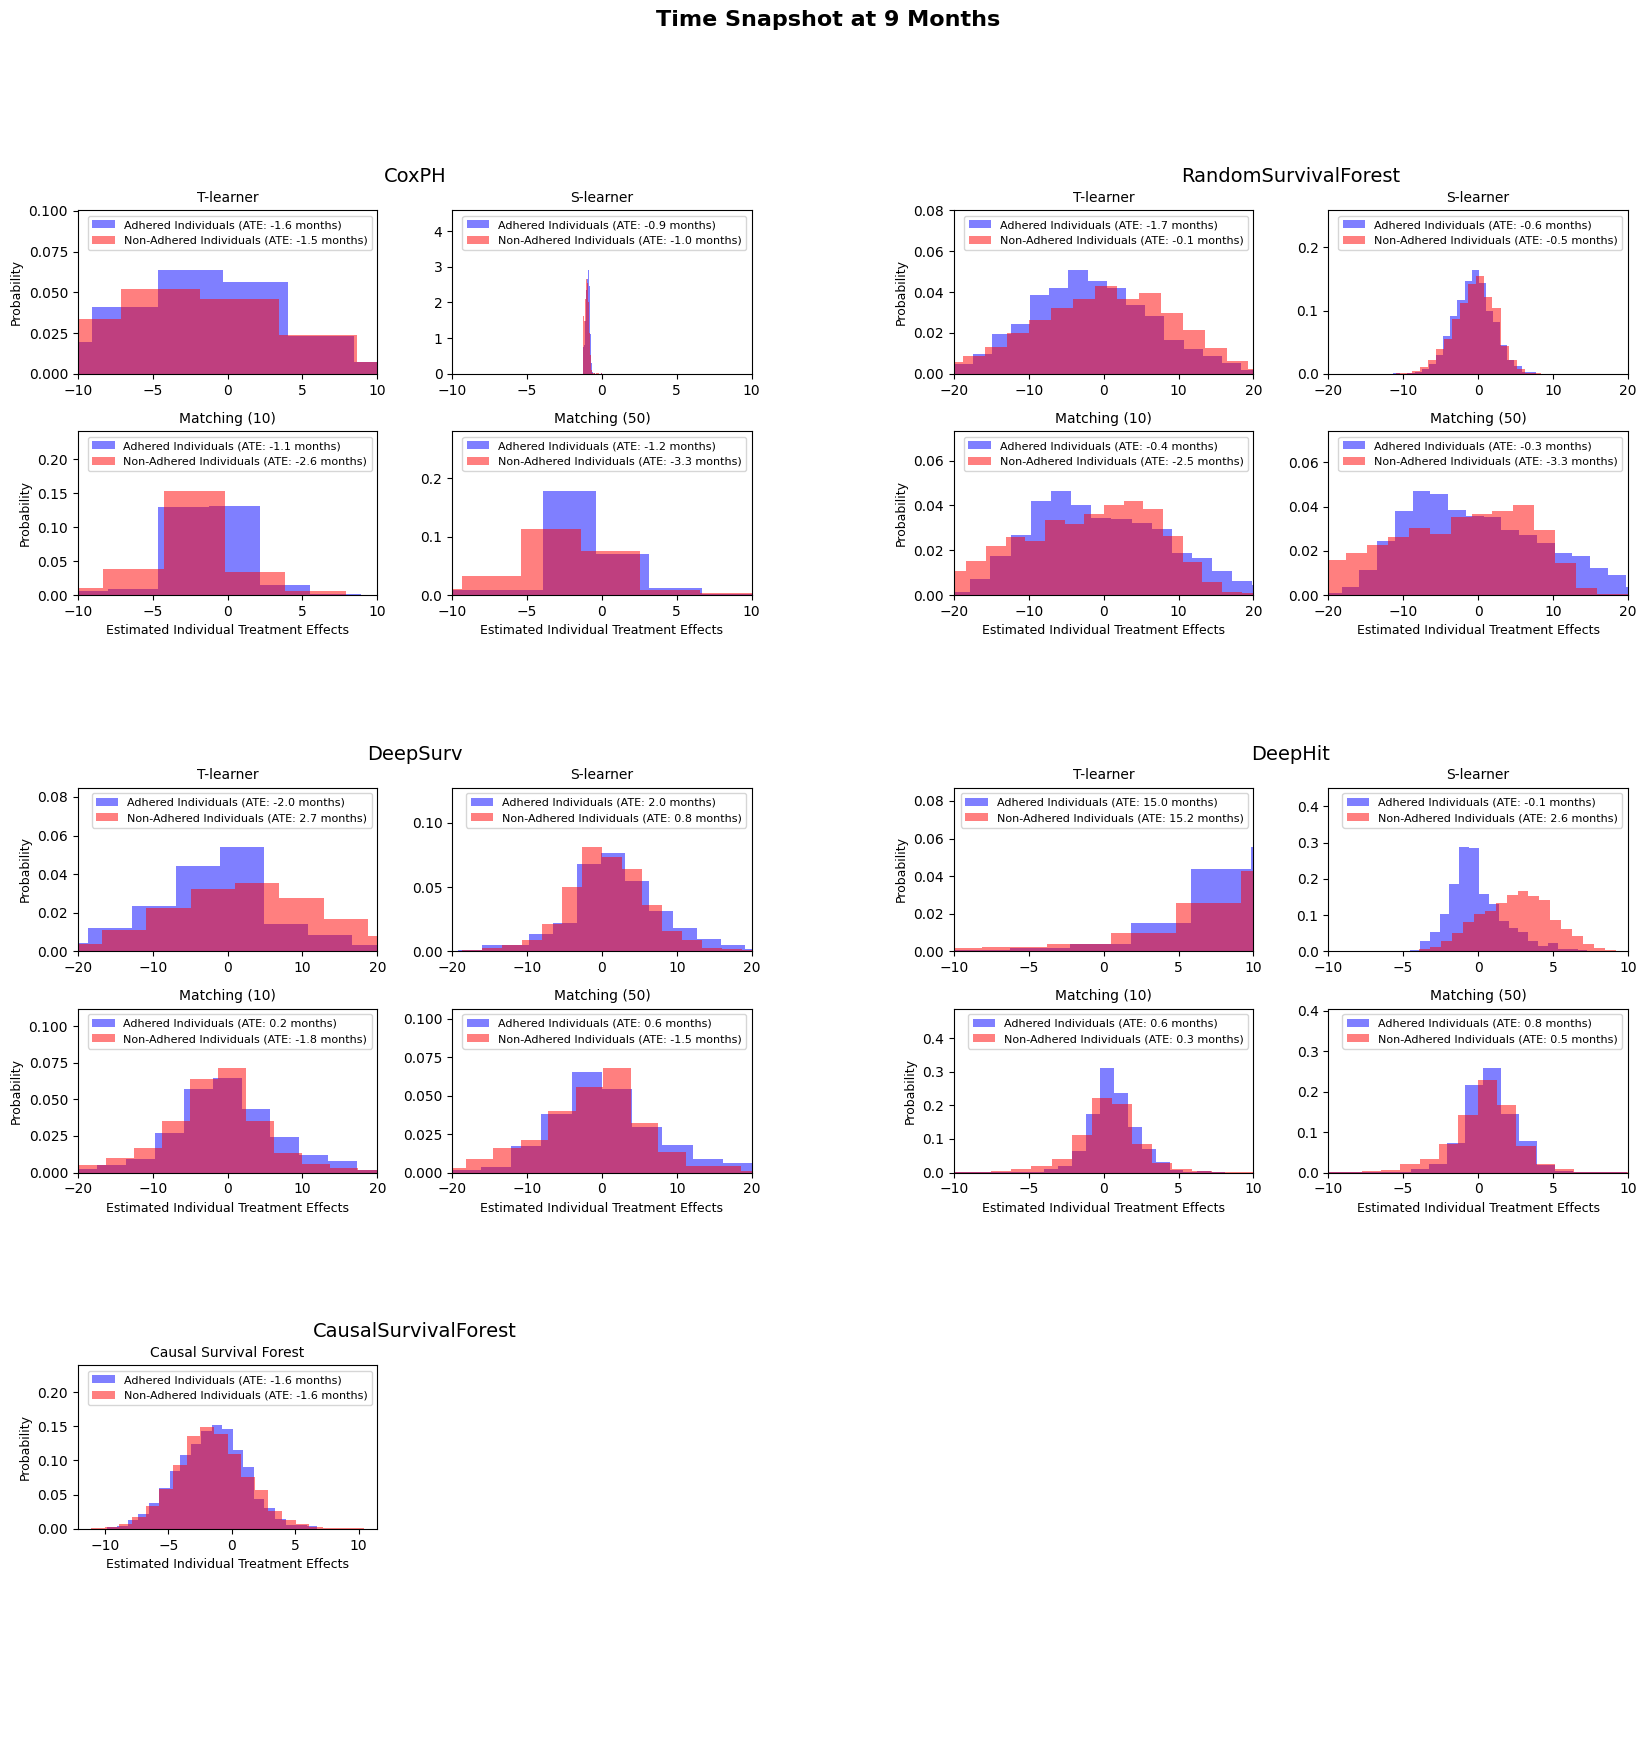

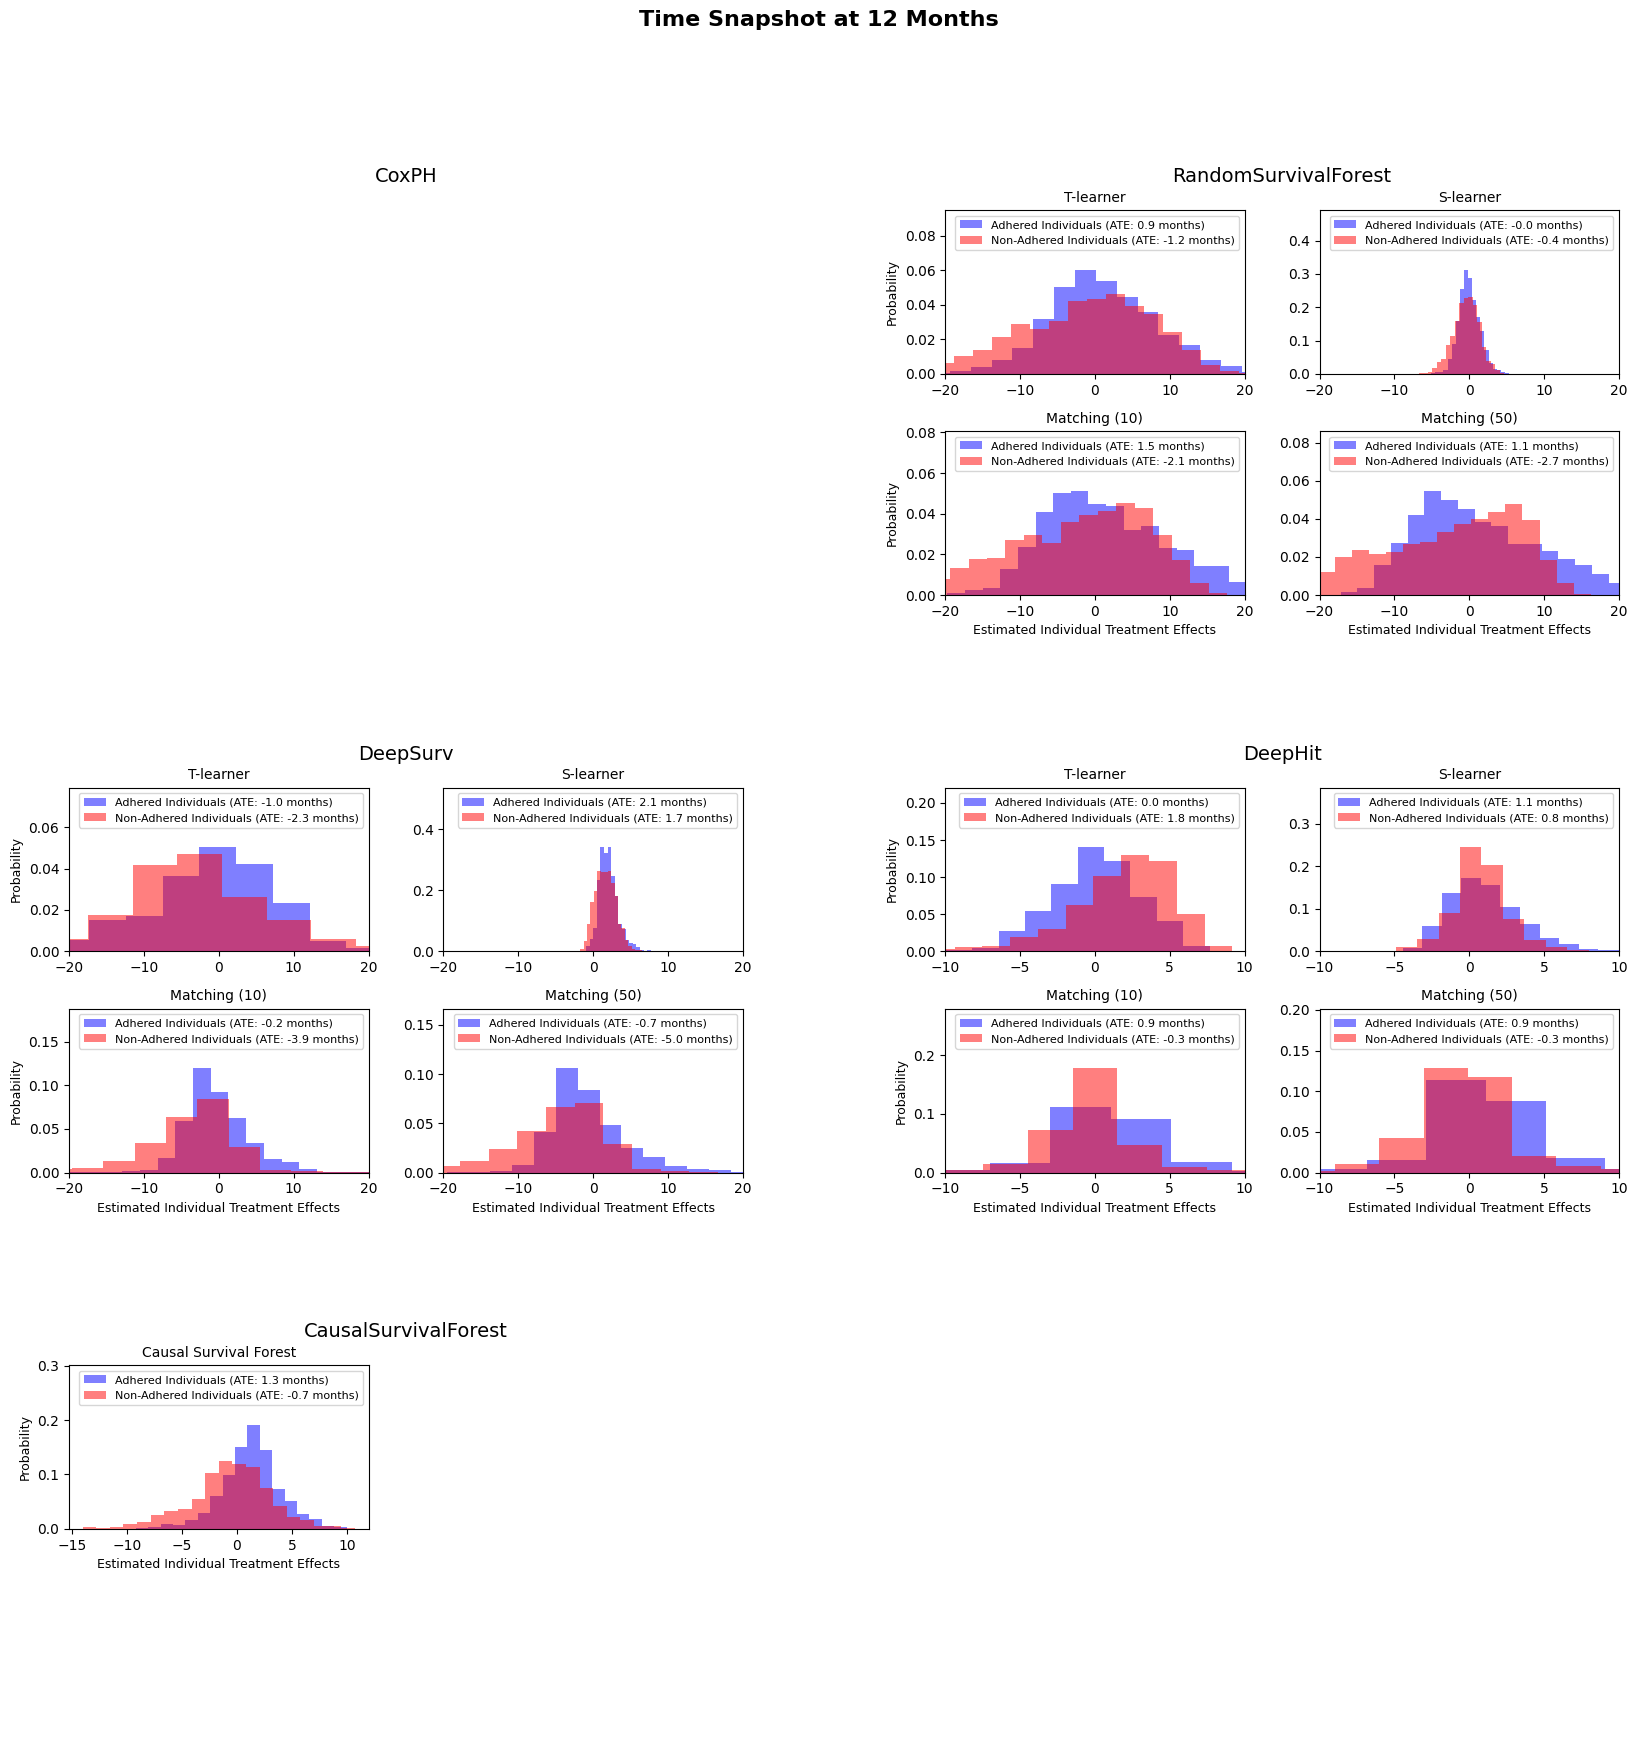

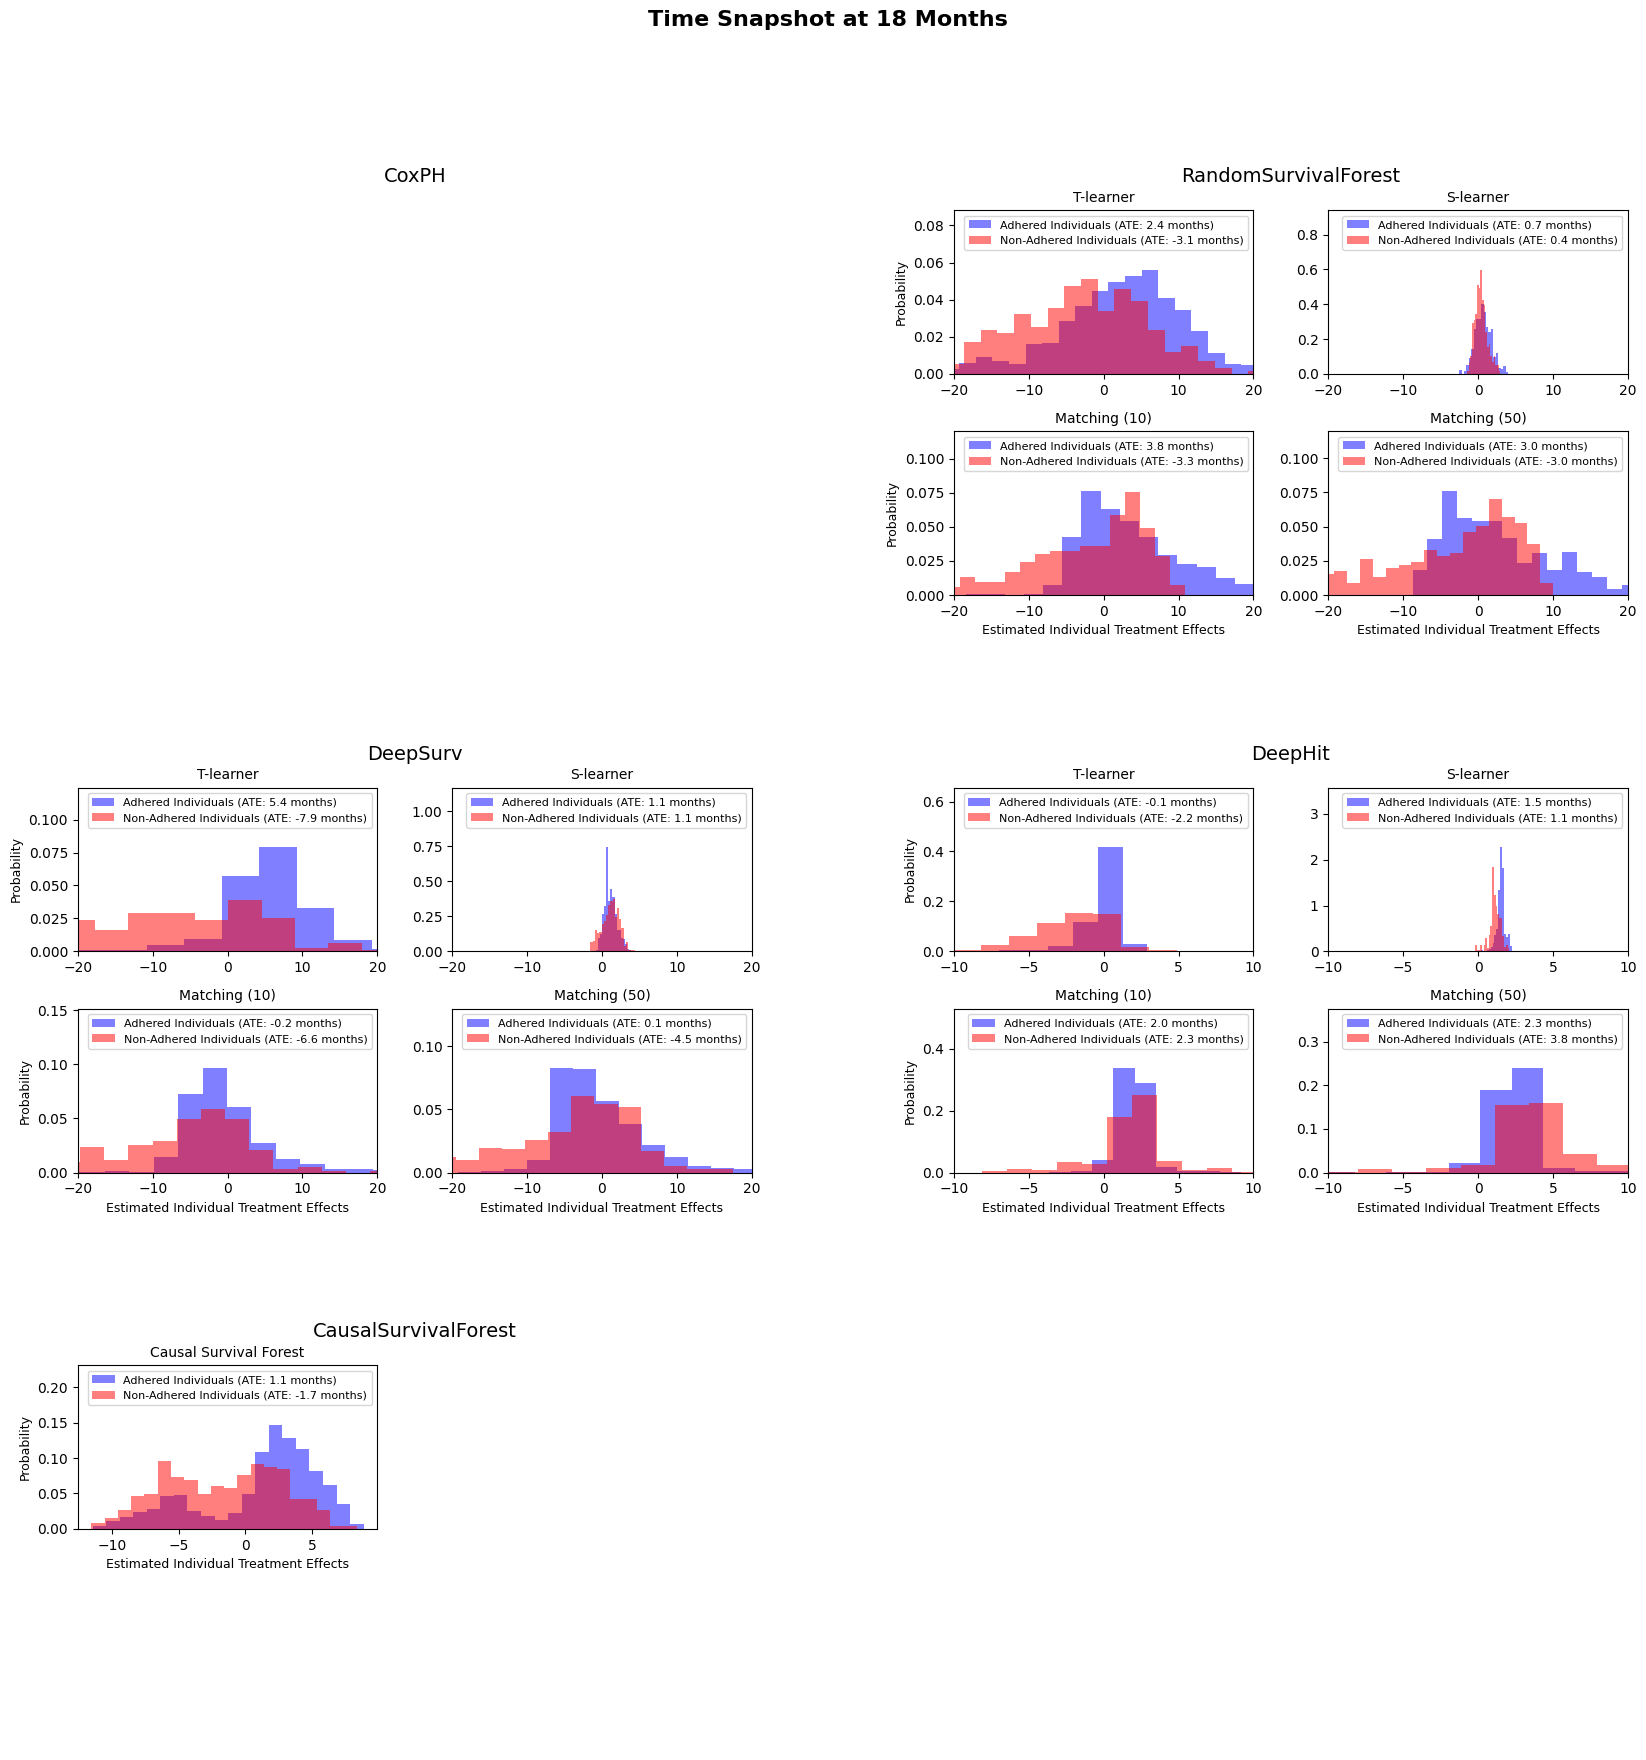

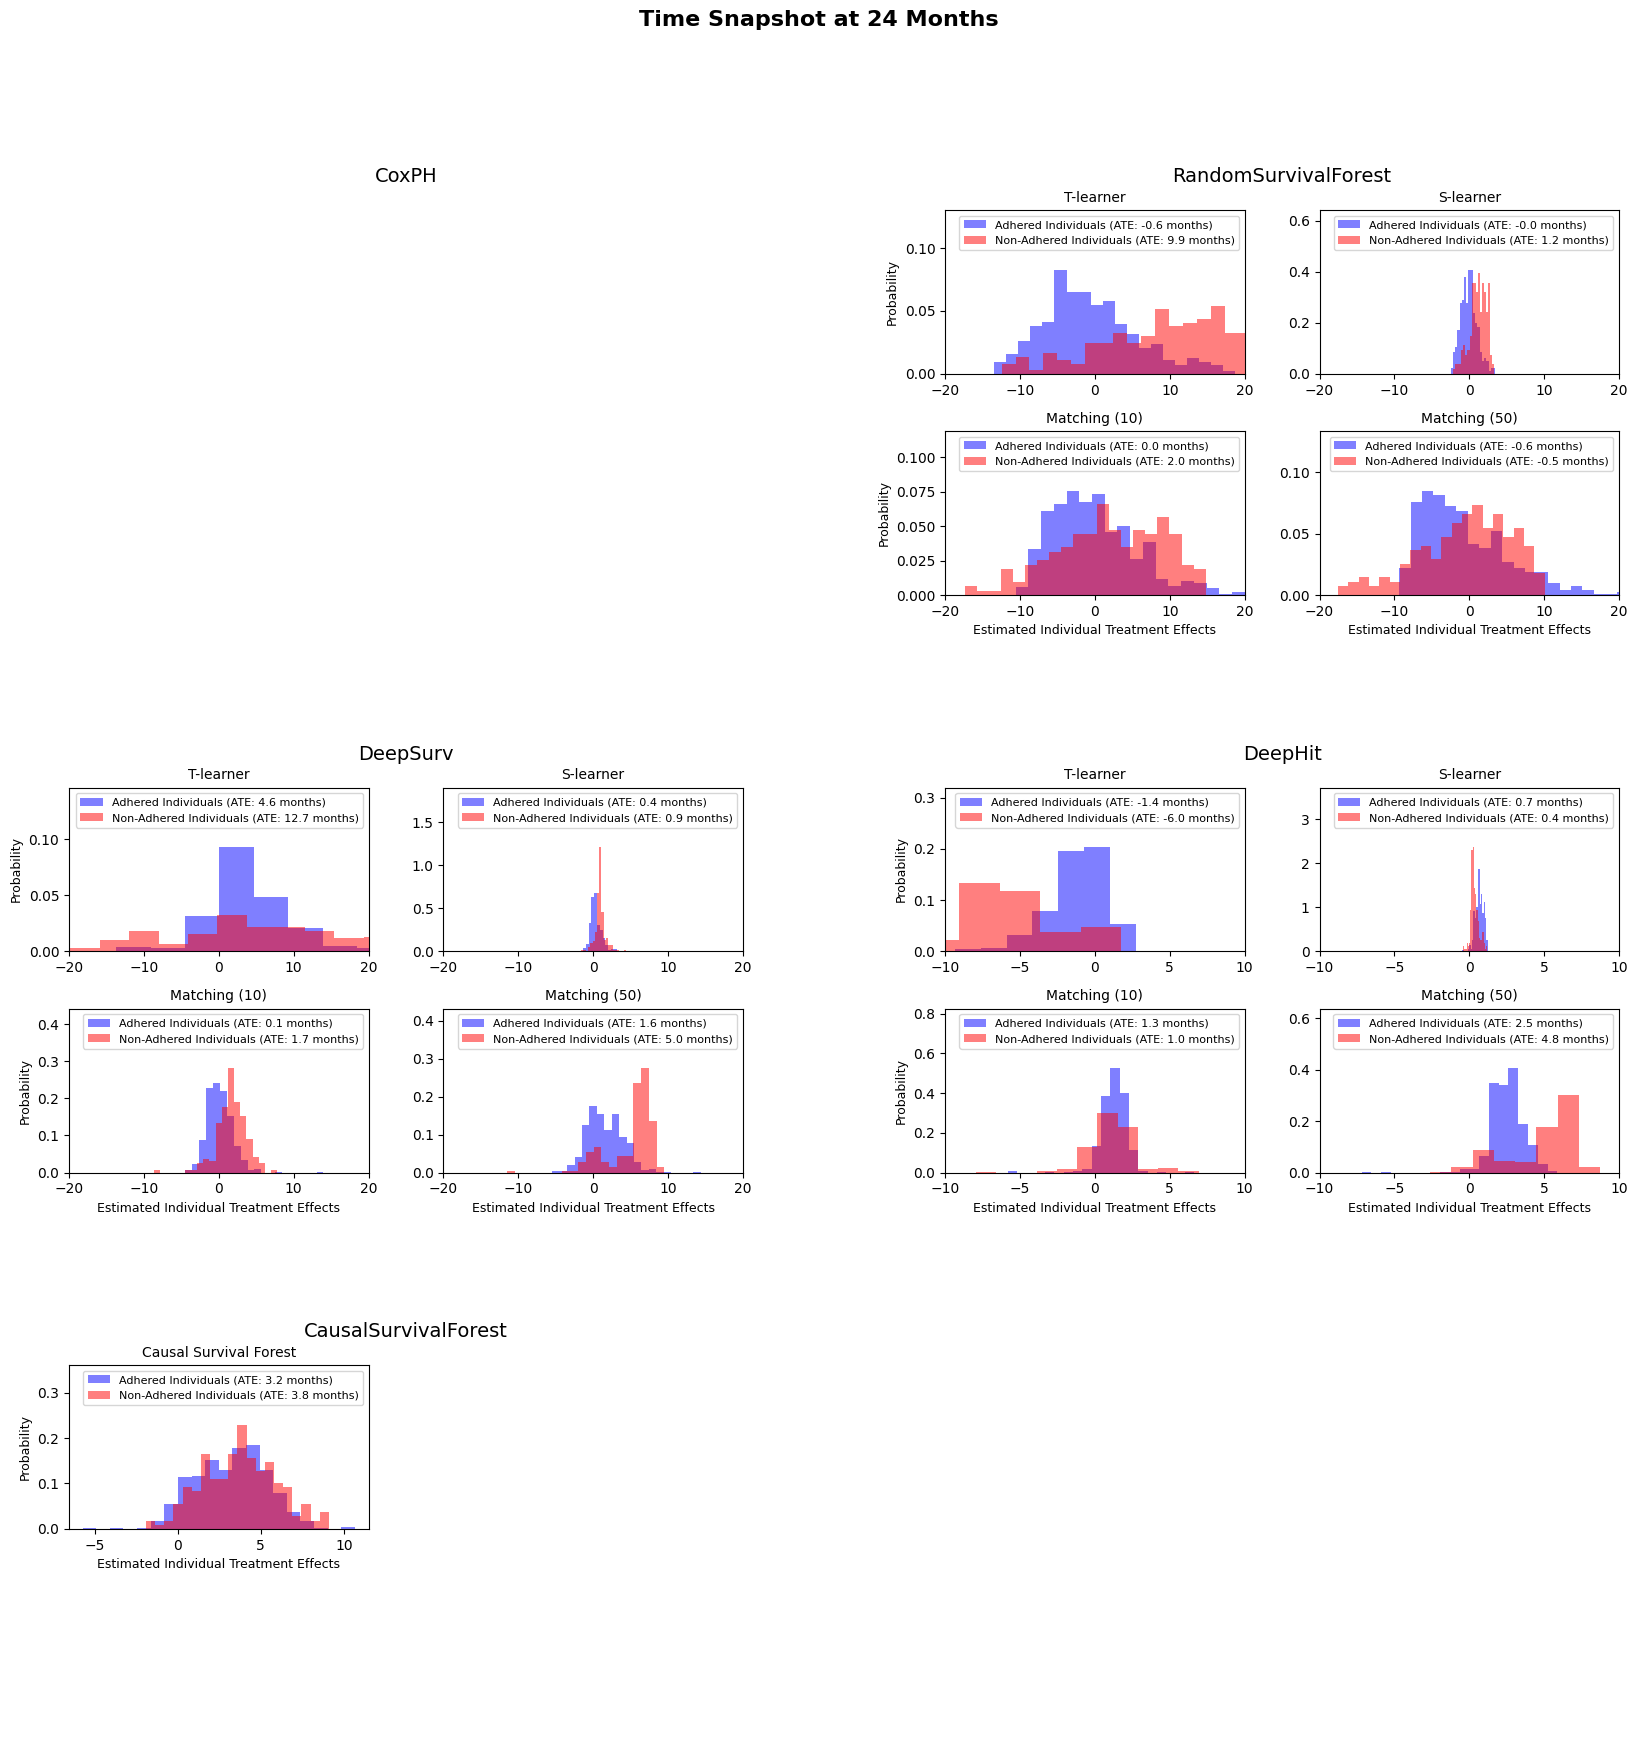

In [80]:
post_hoc_mode = 'A'

for i, time_snapshot in enumerate(individual_treatment_effect_per_time_snapshot):
    
    plot_survival_analysis_results(individual_treatment_effect_per_time_snapshot[time_snapshot], 
                                   outer_grid_spacing_w=0.3, outer_grid_spacing_h=0.5,
                                   inner_grid_spacing_w=0.25, inner_grid_spacing_h=0.35,
                                   post_hoc_mode=post_hoc_mode, figure_title=f"Time Snapshot at {time_snapshot} Months")
    
    if i >= 5: break